# JioPay RAG Chatbot - Chunking Strategies Implementation

This notebook implements 5 different chunking strategies for the JioPay knowledge base:
1. **Fixed Chunking** - Size-based with overlap variations
2. **Semantic Chunking** - Similarity-based grouping  
3. **Structural Chunking** - Document structure preservation
4. **Recursive Chunking** - Hierarchical fallback approach
5. **LLM-based Chunking** - AI-powered semantic boundaries

**Data Sources:**
- JSON FAQ files (jiopay_faq_data_final.json, partner_faq_data.json)
- PDF policy documents (Grievance-Redressal-Policy.pdf, etc.)

**Evaluation Criteria:** Size distribution, coherence, retrieval performance

In [ ]:
# Install required packages for chunking
%pip install PyMuPDF sentence-transformers scikit-learn nltk tiktoken openai tqdm pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Step 1: Install Required Packages

In [5]:
# Import necessary libraries
import json
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Union
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# PDF processing
# import fitz  # PyMuPDF

# NLP libraries
import nltk
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Tokenization
import tiktoken

print("All libraries imported successfully!")

All libraries imported successfully!


## Step 2: Data Loading and Preprocessing

In [ ]:
# Data paths
DATA_DIR = "scraped_data"
CHUNK_OUTPUT_DIR = "chunked_data"

# Create output directory
os.makedirs(CHUNK_OUTPUT_DIR, exist_ok=True)

# Initialize tokenizer for accurate token counting
encoding = tiktoken.get_encoding("cl100k_base")  # GPT-4 tokenizer

def count_tokens(text: str) -> int:
    """Count tokens using tiktoken (more accurate than char/4)"""
    return len(encoding.encode(text))

def text_formatter(text: str) -> str:
    """Clean and format text"""
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {CHUNK_OUTPUT_DIR}")
print("Utility functions defined!")

Data directory: scraped_data
Output directory: chunked_data
Utility functions defined!


In [ ]:
def load_json_data() -> List[Dict[str, Any]]:
    """Load all JSON FAQ data with proper structure handling"""
    json_files = [
        "jiopay_faq_data_final.json",
        "partner_faq_data.json"
    ]

    all_data = []

    for file in json_files:
        file_path = os.path.join(DATA_DIR, file)
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)

            # Handle different JSON structures
            if file == "partner_faq_data.json":
                # Special handling for partner FAQ structure
                if isinstance(data, dict) and 'faq' in data:
                    faq_list = data['faq']
                    for item in faq_list:
                        all_data.append({
                            'source': file,
                            'type': 'faq',
                            'question': item['question'],
                            'answer': item['answer'],
                            'text': f"Q: {item['question']}\\n\\nA: {item['answer']}",
                            'metadata': {'source_file': file}
                        })
                elif isinstance(data, list):
                    # Fallback for list structure
                    for item in data:
                        if isinstance(item, dict) and 'question' in item and 'answer' in item:
                            all_data.append({
                                'source': file,
                                'type': 'faq',
                                'question': item['question'],
                                'answer': item['answer'],
                                'text': f"Q: {item['question']}\\n\\nA: {item['answer']}",
                                'metadata': {'source_file': file}
                            })
            else:
                # Handle general FAQ structure
                for item in data:
                    if isinstance(item, dict):
                        if 'Title' in item and 'Answer' in item:
                            all_data.append({
                                'source': file,
                                'type': 'faq',
                                'question': item['Title'],
                                'answer': item['Answer'],
                                'text': f"Q: {item['Title']}\\n\\nA: {item['Answer']}",
                                'metadata': {'source_file': file}
                            })
                        elif 'question' in item and 'answer' in item:
                            all_data.append({
                                'source': file,
                                'type': 'faq',
                                'question': item['question'],
                                'answer': item['answer'],
                                'text': f"Q: {item['question']}\\n\\nA: {item['answer']}",
                                'metadata': {'source_file': file}
                            })
        else:
            print(f"Warning: {file} not found")

    print(f"Loaded {len(all_data)} FAQ items from JSON files")
    return all_data

def load_web_data() -> List[Dict[str, Any]]:
    """Load web scraped data from Playwright JSON"""
    web_file = "scraped_data_playwright.json"
    web_data = []

    file_path = os.path.join(DATA_DIR, web_file)
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        print(f"Raw data loaded: {len(data)} items")

        for i, item in enumerate(data):
            if isinstance(item, dict) and 'text' in item:
                # Extract URL if available, otherwise use filename
                url = item.get('url', 'unknown_url')
                # Get text content
                text_content = item['text'].strip()

                print(f"Item {i}: URL={url[:50]}..., Text length={len(text_content)}")

                # More lenient filtering conditions
                if text_content and len(text_content) > 100:  # Reduced from 50 to allow more content
                    # Check for JavaScript-only content but be more specific
                    if not ("You need to enable JavaScript to run this app." == text_content.strip()[:50]):
                        web_data.append({
                            'source': url,
                            'type': 'web_page',
                            'text': text_content,
                            'metadata': {
                                'source_file': web_file,
                                'url': url
                            }
                        })
                        print(f"  -> Added to web_data")
                    else:
                        print(f"  -> Skipped: JavaScript-only content")
                else:
                    print(f"  -> Skipped: Text too short ({len(text_content)} chars)")
            else:
                print(f"Item {i}: Not a dict or missing 'text' field")
    else:
        print(f"Warning: {web_file} not found")

    print(f"Final web_data count: {len(web_data)}")
    return web_data

def load_pdf_data() -> List[Dict[str, Any]]:
    """Load and extract text from PDF files"""
    pdf_files = [
        "Grievance-Redressal-Policy.pdf",
        "restricted_business_list.pdf",
        "list_of_documents_for_sole_proprietorship_and-entity.pdf"
    ]

    all_data = []

    for file in pdf_files:
        file_path = os.path.join(DATA_DIR, file)
        if os.path.exists(file_path):
            doc = fitz.open(file_path)
            full_text = ""

            # Store page count before closing the document
            page_count = len(doc)

            for page_num in range(page_count):
                page = doc.load_page(page_num)
                text = page.get_text()
                text = text_formatter(text)
                full_text += text + " "

            doc.close()

            if full_text.strip():
                all_data.append({
                    'source': file,
                    'type': 'pdf',
                    'text': full_text.strip(),
                    'metadata': {
                        'source_file': file,
                        'pages': page_count,  # Use the stored page count
                        'char_count': len(full_text)
                    }
                })
        else:
            print(f"Warning: {file} not found")

    print(f"Loaded {len(all_data)} PDF documents")
    return all_data

# Load all data
json_data = load_json_data()
pdf_data = load_pdf_data()
web_data = load_web_data()

print(f"\\nTotal data loaded:")
print(f"- FAQ items: {len(json_data)}")
print(f"- PDF documents: {len(pdf_data)}")
print(f"- Web pages: {len(web_data)}")
print(f"- Total items: {len(json_data) + len(pdf_data) + len(web_data)}")

Loaded 100 FAQ items from JSON files
Loaded 3 PDF documents
Raw data loaded: 25 items
Item 0: URL=https://www.jiopay.com/business/..., Text length=2878
  -> Added to web_data
Item 1: URL=https://www.jiopay.com/business/about-us..., Text length=4574
  -> Added to web_data
Item 2: URL=https://www.jiopay.com/business/contact..., Text length=4070
  -> Added to web_data
Item 3: URL=https://www.jiopay.com/business/paymentgateway..., Text length=6266
  -> Added to web_data
Item 4: URL=https://www.jiopay.com/business/paymentgateway/dir..., Text length=5073
  -> Added to web_data
Item 5: URL=https://www.jiopay.com/business/paymentgateway/che..., Text length=4907
  -> Added to web_data
Item 6: URL=https://www.jiopay.com/business/paymentgateway/vau..., Text length=4784
  -> Added to web_data
Item 7: URL=https://www.jiopay.com/business/paymentgateway/col..., Text length=4866
  -> Added to web_data
Item 8: URL=https://www.jiopay.com/business/paymentgateway/rep..., Text length=4960
  -> Added to web

In [ ]:
import os
import json
from datetime import datetime
from typing import Dict, List, Any

def create_chunks_directory():
    """Create organized directory structure for saving chunks"""
    base_dir = "chunked_data"
    subdirs = [
        "fixed_chunking",
        "semantic_chunking",
        "structural_chunking",
        "recursive_chunking",
        "llm_chunking",
        "intelligent_chunking",
        "analysis_results"
    ]

    # Create base directory
    os.makedirs(base_dir, exist_ok=True)

    # Create subdirectories
    for subdir in subdirs:
        os.makedirs(os.path.join(base_dir, subdir), exist_ok=True)

    print(f"✅ Created chunk storage directories in '{base_dir}/'")
    return base_dir

def save_chunks_to_json(chunks: List[Dict], method_name: str, config: Dict = None):
    """
    Save chunks to JSON with metadata and configuration details

    Args:
        chunks: List of chunk dictionaries
        method_name: Name of chunking method (e.g., 'fixed_256_0', 'semantic_512')
        config: Configuration parameters used
    """
    if not chunks:
        print(f"⚠️  No chunks to save for {method_name}")
        return

    # Create filename with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{method_name}_{timestamp}.json"

    # Determine subdirectory based on method
    if 'fixed' in method_name.lower():
        subdir = "fixed_chunking"
    elif 'semantic' in method_name.lower():
        subdir = "semantic_chunking"
    elif 'structural' in method_name.lower():
        subdir = "structural_chunking"
    elif 'recursive' in method_name.lower():
        subdir = "recursive_chunking"
    elif 'llm' in method_name.lower():
        subdir = "llm_chunking"
    elif 'intelligent' in method_name.lower():
        subdir = "intelligent_chunking"
    else:
        subdir = "analysis_results"

    filepath = os.path.join("chunked_data", subdir, filename)

    # Calculate statistics
    token_counts = [chunk.get('token_count', 0) for chunk in chunks]
    data_types = {}
    for chunk in chunks:
        chunk_type = chunk.get('type', 'unknown')
        data_types[chunk_type] = data_types.get(chunk_type, 0) + 1

    # Create comprehensive save data
    save_data = {
        "metadata": {
            "method_name": method_name,
            "timestamp": timestamp,
            "total_chunks": len(chunks),
            "configuration": config or {},
            "statistics": {
                "avg_tokens": sum(token_counts) / len(token_counts) if token_counts else 0,
                "min_tokens": min(token_counts) if token_counts else 0,
                "max_tokens": max(token_counts) if token_counts else 0,
                "total_tokens": sum(token_counts),
                "data_type_distribution": data_types
            },
            "data_sources": {
                "faq_files": ["jiopay_faq_data_final.json", "partner_faq_data.json"],
                "pdf_files": ["Grievance-Redressal-Policy.pdf", "restricted_business_list.pdf",
                             "list_of_documents_for_sole_proprietorship_and-entity.pdf"],
                "web_files": ["scraped_data_playwright.json"]
            }
        },
        "chunks": chunks
    }

    # Save to JSON
    with open(filepath, 'w', encoding='utf-8') as f:
        json.dump(save_data, f, indent=2, ensure_ascii=False)

    print(f"💾 Saved {len(chunks)} chunks to: {filepath}")
    print(f"   📊 Stats: Avg {save_data['metadata']['statistics']['avg_tokens']:.1f} tokens, "
          f"{save_data['metadata']['statistics']['total_tokens']} total tokens")
    print(f"   📁 Types: {', '.join([f'{k}({v})' for k, v in data_types.items()])}")

def save_analysis_results(results: Dict, filename: str = None):
    """Save comparative analysis results"""
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"chunking_analysis_{timestamp}.json"

    filepath = os.path.join("chunked_data", "analysis_results", filename)

    with open(filepath, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)

    print(f"📈 Analysis results saved to: {filepath}")

def load_saved_chunks(method_name: str = None, latest: bool = True) -> Dict:
    """
    Load previously saved chunks

    Args:
        method_name: Specific method to load (None for all)
        latest: Whether to load only the latest version
    """
    base_dir = "chunked_data"
    if not os.path.exists(base_dir):
        print("❌ No saved chunks found")
        return {}

    saved_chunks = {}

    for subdir in os.listdir(base_dir):
        subdir_path = os.path.join(base_dir, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                if file.endswith('.json'):
                    if method_name and method_name not in file:
                        continue

                    filepath = os.path.join(subdir_path, file)
                    with open(filepath, 'r', encoding='utf-8') as f:
                        data = json.load(f)

                    method = data['metadata']['method_name']
                    saved_chunks[method] = data

    print(f"📂 Loaded {len(saved_chunks)} saved chunk sets")
    return saved_chunks

# Create the directory structure
create_chunks_directory()
print("🚀 Chunk saving system initialized!")

✅ Created chunk storage directories in 'chunked_data/'
🚀 Chunk saving system initialized!


## Step 3: Chunking Strategy 1 - Fixed Size Chunking

**Implementation:** Character/token-based splitting with configurable size and overlap.  
**Variations:** 256, 512, 1024 tokens with 0, 64, 128 token overlaps (9 combinations total)

In [ ]:
def fixed_chunk_text(text: str, chunk_size_tokens: int = 512, overlap_tokens: int = 64) -> List[str]:
    """
    Split text into fixed-size chunks with overlap based on tokens.
    """
    tokens = encoding.encode(text)
    chunks = []

    start = 0
    while start < len(tokens):
        end = start + chunk_size_tokens
        chunk_tokens = tokens[start:end]
        chunk_text = encoding.decode(chunk_tokens)

        if chunk_text.strip():
            chunks.append(chunk_text.strip())

        # Move start position (chunk_size - overlap for next chunk)
        start = start + chunk_size_tokens - overlap_tokens

        # If remaining tokens are too small and we have overlap, break
        if end >= len(tokens):
            break

    return chunks

def apply_fixed_chunking(all_data: List[Dict], chunk_size: int, overlap: int) -> List[Dict]:
    """Apply fixed chunking to all data sources"""
    chunks = []
    chunk_id = 0

    for item in all_data:
        text = item['text']

        if item['type'] == 'faq':
            # For FAQ, check if it fits in one chunk
            if count_tokens(text) <= chunk_size:
                chunks.append({
                    'chunk_id': chunk_id,
                    'text': text,
                    'source': item['source'],
                    'type': item['type'],
                    'chunk_method': 'fixed',
                    'chunk_size': chunk_size,
                    'overlap': overlap,
                    'token_count': count_tokens(text),
                    'metadata': item['metadata']
                })
                chunk_id += 1
            else:
                # Split long FAQ answers
                sub_chunks = fixed_chunk_text(text, chunk_size, overlap)
                for i, chunk_text in enumerate(sub_chunks):
                    chunks.append({
                        'chunk_id': chunk_id,
                        'text': chunk_text,
                        'source': item['source'],
                        'type': item['type'],
                        'chunk_method': 'fixed',
                        'chunk_size': chunk_size,
                        'overlap': overlap,
                        'token_count': count_tokens(chunk_text),
                        'metadata': {**item['metadata'], 'sub_chunk': i}
                    })
                    chunk_id += 1

        elif item['type'] == 'web_page':
            # For web pages, always split
            sub_chunks = fixed_chunk_text(text, chunk_size, overlap)
            for i, chunk_text in enumerate(sub_chunks):
                chunks.append({
                    'chunk_id': chunk_id,
                    'text': chunk_text,
                    'source': item['source'],
                    'type': item['type'],
                    'chunk_method': 'fixed',
                    'chunk_size': chunk_size,
                    'overlap': overlap,
                    'token_count': count_tokens(chunk_text),
                    'metadata': {**item['metadata'], 'sub_chunk': i}
                })
                chunk_id += 1

        else:  # PDF documents
            sub_chunks = fixed_chunk_text(text, chunk_size, overlap)
            for i, chunk_text in enumerate(sub_chunks):
                chunks.append({
                    'chunk_id': chunk_id,
                    'text': chunk_text,
                    'source': item['source'],
                    'type': item['type'],
                    'chunk_method': 'fixed',
                    'chunk_size': chunk_size,
                    'overlap': overlap,
                    'token_count': count_tokens(chunk_text),
                    'metadata': {**item['metadata'], 'sub_chunk': i}
                })
                chunk_id += 1

    return chunks

# Apply fixed chunking with different configurations
fixed_configs = [
    (256, 0), (256, 64), (256, 128),
    (512, 0), (512, 64), (512, 128),
    (1024, 0), (1024, 64), (1024, 128)
]

fixed_results = {}

print("Applying Fixed Chunking Strategies...")
all_data_combined = json_data + pdf_data + web_data
for chunk_size, overlap in tqdm(fixed_configs):
    config_name = f"fixed_{chunk_size}_{overlap}"
    chunks = apply_fixed_chunking(all_data_combined, chunk_size, overlap)
    fixed_results[config_name] = chunks

    print(f"Config {config_name}: {len(chunks)} chunks generated")

print(f"\\nFixed chunking complete! Generated {len(fixed_results)} configurations.")

Applying Fixed Chunking Strategies...


 22%|██▏       | 2/9 [00:00<00:00, 18.17it/s]

Config fixed_256_0: 328 chunks generated
Config fixed_256_64: 388 chunks generated
Config fixed_256_128: 510 chunks generated


 44%|████▍     | 4/9 [00:00<00:00, 18.20it/s]

Config fixed_512_0: 221 chunks generated
Config fixed_512_64: 236 chunks generated


 78%|███████▊  | 7/9 [00:00<00:00, 19.80it/s]

Config fixed_512_128: 248 chunks generated
Config fixed_1024_0: 168 chunks generated
Config fixed_1024_64: 170 chunks generated


100%|██████████| 9/9 [00:00<00:00, 19.78it/s]

Config fixed_1024_128: 172 chunks generated
\nFixed chunking complete! Generated 9 configurations.


In [ ]:
# Save all fixed chunking configurations
print("\n💾 Saving fixed chunking results...")
for config_name, chunks in fixed_results.items():
    # Extract size and overlap from config name (e.g., "fixed_512_64")
    parts = config_name.replace('fixed_', '').split('_')
    size, overlap = int(parts[0]), int(parts[1])

    save_chunks_to_json(chunks, config_name, {
        "chunk_size": size,
        "overlap": overlap,
        "method": "fixed_chunking",
        "description": f"Fixed-size chunking with {size} tokens and {overlap} token overlap"
    })

print("✅ Fixed chunking results saved!")


💾 Saving fixed chunking results...
💾 Saved 328 chunks to: chunked_data\fixed_chunking\fixed_256_0_20250913_194714.json
   📊 Stats: Avg 190.5 tokens, 62477 total tokens
   📁 Types: faq(101), pdf(27), web_page(200)
💾 Saved 388 chunks to: chunked_data\fixed_chunking\fixed_256_64_20250913_194714.json
   📊 Stats: Avg 203.9 tokens, 79107 total tokens
   📁 Types: faq(101), pdf(34), web_page(253)
💾 Saved 510 chunks to: chunked_data\fixed_chunking\fixed_256_128_20250913_194714.json
   📊 Stats: Avg 218.3 tokens, 111358 total tokens
   📁 Types: faq(101), pdf(48), web_page(361)
💾 Saved 221 chunks to: chunked_data\fixed_chunking\fixed_512_0_20250913_194714.json
   📊 Stats: Avg 282.7 tokens, 62481 total tokens
   📁 Types: faq(100), pdf(15), web_page(106)
💾 Saved 236 chunks to: chunked_data\fixed_chunking\fixed_512_64_20250913_194714.json
   📊 Stats: Avg 294.0 tokens, 69394 total tokens
   📁 Types: faq(100), pdf(16), web_page(120)
💾 Saved 248 chunks to: chunked_data\fixed_chunking\fixed_512_128_2025

## Step 4: Chunking Strategy 2 - Semantic Chunking

**Implementation:** Groups content by semantic similarity using sentence embeddings.  
**For FAQs:** Groups related questions by topic similarity.  
**For PDFs:** Groups sentences with similar meanings.

In [ ]:
# Download NLTK data
import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Load semantic model
print("Loading sentence transformer model...")
semantic_model = SentenceTransformer("all-MiniLM-L6-v2")
print("Model loaded successfully!")

def semantic_chunk_faqs(faq_data: List[Dict], similarity_threshold: float = 0.60, max_tokens: int = 1024) -> List[Dict]:
    """Group FAQs by semantic similarity of questions"""
    if not faq_data:
        return []

    # Extract questions and compute embeddings
    questions = [item['question'] for item in faq_data]
    embeddings = semantic_model.encode(questions)

    # Group similar questions
    chunks = []
    used_indices = set()
    chunk_id = 0

    for i, item in enumerate(faq_data):
        if i in used_indices:
            continue

        # Start new group with current FAQ
        current_group = [item]
        current_tokens = count_tokens(item['text'])
        used_indices.add(i)

        # Find similar FAQs to group together
        for j, other_item in enumerate(faq_data):
            if j in used_indices or j == i:
                continue

            # Check similarity
            similarity = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]

            if similarity >= similarity_threshold:
                potential_tokens = current_tokens + count_tokens(other_item['text'])

                # Add if it fits within token limit
                if potential_tokens <= max_tokens:
                    current_group.append(other_item)
                    current_tokens = potential_tokens
                    used_indices.add(j)

        # Create chunk from group
        if len(current_group) == 1:
            # Single FAQ
            chunk_text = current_group[0]['text']
        else:
            # Multiple related FAQs
            chunk_text = "\\n\\n".join([faq['text'] for faq in current_group])

        chunks.append({
            'chunk_id': chunk_id,
            'text': chunk_text,
            'source': current_group[0]['source'],
            'type': 'faq_group',
            'chunk_method': 'semantic',
            'similarity_threshold': similarity_threshold,
            'max_tokens': max_tokens,
            'token_count': count_tokens(chunk_text),
            'faq_count': len(current_group),
            'metadata': {
                'source_files': list(set([faq['metadata']['source_file'] for faq in current_group])),
                'topics': [faq['question'][:50] + "..." for faq in current_group]
            }
        })
        chunk_id += 1

    return chunks

def semantic_chunk_pdf(pdf_text: str, source: str, metadata: Dict,
                      similarity_threshold: float = 0.6, max_tokens: int = 1024) -> List[Dict]:
    """Chunk PDF text by semantic similarity of sentences"""
    sentences = nltk.sent_tokenize(pdf_text)
    if not sentences:
        return []

    # Compute embeddings for sentences
    embeddings = semantic_model.encode(sentences)

    chunks = []
    chunk_id = 0
    current_chunk = [sentences[0]]
    current_embedding = embeddings[0]

    for i in range(1, len(sentences)):
        similarity = cosine_similarity([current_embedding], [embeddings[i]])[0][0]

        # Check if adding sentence exceeds token limit
        potential_text = " ".join(current_chunk + [sentences[i]])
        potential_tokens = count_tokens(potential_text)

        if similarity >= similarity_threshold and potential_tokens <= max_tokens:
            current_chunk.append(sentences[i])
            # Update embedding to average
            current_embedding = np.mean([current_embedding, embeddings[i]], axis=0)
        else:
            # Finalize current chunk
            chunk_text = " ".join(current_chunk)
            chunks.append({
                'chunk_id': chunk_id,
                'text': chunk_text,
                'source': source,
                'type': 'pdf',
                'chunk_method': 'semantic',
                'similarity_threshold': similarity_threshold,
                'max_tokens': max_tokens,
                'token_count': count_tokens(chunk_text),
                'sentence_count': len(current_chunk),
                'metadata': metadata
            })

            # Start new chunk
            current_chunk = [sentences[i]]
            current_embedding = embeddings[i]
            chunk_id += 1

    # Add final chunk
    if current_chunk:
        chunk_text = " ".join(current_chunk)
        chunks.append({
            'chunk_id': chunk_id,
            'text': chunk_text,
            'source': source,
            'type': 'pdf',
            'chunk_method': 'semantic',
            'similarity_threshold': similarity_threshold,
            'max_tokens': max_tokens,
            'token_count': count_tokens(chunk_text),
            'sentence_count': len(current_chunk),
            'metadata': metadata
        })

    return chunks

def apply_semantic_chunking(json_data: List[Dict], pdf_data: List[Dict], web_data: List[Dict],
                           similarity_threshold: float = 0.60, max_tokens: int = 1024) -> List[Dict]:
    """Apply semantic chunking to all data"""
    chunks = []

    # Process FAQ data
    faq_chunks = semantic_chunk_faqs(json_data, similarity_threshold, max_tokens)
    chunks.extend(faq_chunks)

    # Process PDF data
    for pdf_item in pdf_data:
        pdf_chunks = semantic_chunk_pdf(
            pdf_item['text'],
            pdf_item['source'],
            pdf_item['metadata'],
            similarity_threshold,
            max_tokens
        )
        chunks.extend(pdf_chunks)

    # Process Web data
    for web_item in web_data:
        web_chunks = semantic_chunk_pdf(
            web_item['text'],
            web_item['source'],
            web_item['metadata'],
            similarity_threshold,
            max_tokens
        )
        chunks.extend(web_chunks)

    # Update chunk IDs to be sequential
    for i, chunk in enumerate(chunks):
        chunk['chunk_id'] = i

    return chunks

# Apply semantic chunking
print("Applying Semantic Chunking...")
semantic_chunks = apply_semantic_chunking(json_data, pdf_data, web_data, similarity_threshold=0.70, max_tokens=800)

print(f"Semantic chunking complete! Generated {len(semantic_chunks)} chunks.")
print(f"FAQ groups: {len([c for c in semantic_chunks if c['type'] == 'faq_group'])}")
print(f"PDF chunks: {len([c for c in semantic_chunks if c['type'] == 'pdf'])}")
print(f"Web chunks: {len([c for c in semantic_chunks if c['type'] == 'pdf' and 'url' in c.get('metadata', {})])}")

Loading sentence transformer model...


No sentence-transformers model found with name sentence-transformers/all-MiniLM-L6-v2. Creating a new one with mean pooling.


SSLError: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /sentence-transformers/all-MiniLM-L6-v2/resolve/main/adapter_config.json (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1020)')))"), '(Request ID: 355e6acb-7b57-4c69-beb1-9884b6aaa0a2)')

In [ ]:
# Save semantic chunking results
print("\nSaving semantic chunking results...")
save_chunks_to_json(semantic_chunks, "semantic_1024", {
    "target_tokens": 1024,
    "similarity_threshold": 0.60,
    "method": "semantic_chunking",
    "model": "all-MiniLM-L6-v2",
    "description": "Semantic similarity-based chunking using sentence transformers"
})
print("Semantic chunking results saved!")


💾 Saving semantic chunking results...
💾 Saved 736 chunks to: chunked_data\semantic_chunking\semantic_1024_20250913_201140.json
   📊 Stats: Avg 84.9 tokens, 62505 total tokens
   📁 Types: faq_group(57), pdf(679)
✅ Semantic chunking results saved!


## Step 5: Chunking Strategy 3 - Structural Chunking

**Implementation:** Preserves document structure and logical organization.  
**For FAQs:** Groups by categories or topics if available.  
**For PDFs:** Detects headings, sections, and subsections.

In [ ]:
def extract_faq_topics(faq_data: List[Dict]) -> Dict[str, List[Dict]]:
    """Categorize FAQs by topic using keyword matching"""

    # Define topic keywords
    topic_keywords = {
        'collect_links': ['collect link', 'payment link', 'link validity', 'bulk collect', 'partial payment'],
        'voicebox': ['voicebox', 'voice box', 'audio', 'announcement', 'replay'],
        'settlements': ['settlement', 'bank account', 'UTR', 'refund'],
        'app_dashboard': ['app', 'dashboard', 'login', 'password', 'download', 'forgot', 'reset', 'signin'],
        'transactions': ['transaction', 'payment', 'refund', 'failed'],
        'repeat_payments': ['repeat', 'recurring', 'subscription', 'mandate'],
        'campaigns': ['campaign', 'offer', 'create campaign', 'edit campaign'],
        'user_management': ['sub user', 'user management', 'block user'],
        'dqr': ['DQR', 'dynamic QR', 'store manager'],
        'partner_program': ['partner', 'commission', 'earning'],
        'p2pm_merchants': ['P2PM', 'merchant limit', 'upgrade'],
        'payment_gateway': ['payment', 'gateway', 'transaction', 'processing', 'checkout'],
        'app_usage': ['app', 'download', 'install', 'mobile', 'android', 'ios'],
        'business_setup': ['business', 'setup', 'merchant', 'onboarding', 'registration'],
        'technical_issues': ['error', 'issue', 'problem', 'troubleshoot', 'fix', 'bug'],
        'refunds': ['refund', 'return', 'cancel', 'reverse', 'chargeback'],
        'kyc_documents': ['kyc', 'documents', 'verification', 'identity', 'proof'],
        'fees_pricing': ['fee', 'charge', 'cost', 'price', 'rate', 'commission'],
        'general': []  # fallback category
    }

    categorized = {topic: [] for topic in topic_keywords.keys()}

    for faq in faq_data:
        question = faq['question'].lower()
        answer = faq['answer'].lower()
        text = question + " " + answer

        # Find best matching topic
        best_topic = 'general'
        best_score = 0

        for topic, keywords in topic_keywords.items():
            if topic == 'general':
                continue
            score = sum(1 for keyword in keywords if keyword in text)
            if score > best_score:
                best_score = score
                best_topic = topic

        categorized[best_topic].append(faq)

    return categorized

def detect_pdf_sections(text: str) -> List[Dict[str, Union[str, int]]]:
    """Detect sections in PDF text using common patterns"""

    # Common section patterns
    section_patterns = [
        r'^\\d+\\.\\s+[A-Z][^\\n]{10,100}$',  # 1. Section Title
        r'^[A-Z][A-Z\\s]{5,50}$',              # ALL CAPS HEADINGS
        r'^[A-Z][a-z\\s]{10,80}:$',            # Title with colon
        r'^\\*\\*[^\\*]+\\*\\*$',              # **Bold headings**
        r'^#+\\s+[^\\n]+$',                    # # Markdown headers
    ]

    lines = text.split('\\n')
    sections = []
    current_section = {'title': 'Introduction', 'start': 0, 'content': ''}

    for i, line in enumerate(lines):
        line = line.strip()
        if not line:
            continue

        # Check if line matches section pattern
        is_section = False
        for pattern in section_patterns:
            if re.match(pattern, line, re.MULTILINE):
                is_section = True
                break

        if is_section and current_section['content'].strip():
            # Finalize previous section
            current_section['end'] = i
            sections.append(current_section)

            # Start new section
            current_section = {
                'title': line[:100],  # Limit title length
                'start': i,
                'content': ''
            }
        else:
            current_section['content'] += line + ' '

    # Add final section
    if current_section['content'].strip():
        current_section['end'] = len(lines)
        sections.append(current_section)

    return sections

def structural_chunk_faqs(faq_data: List[Dict], max_tokens: int = 512) -> List[Dict]:
    """Chunk FAQs by structural/topical categories"""
    categorized = extract_faq_topics(faq_data)
    chunks = []
    chunk_id = 0

    for topic, faqs in categorized.items():
        if not faqs:
            continue

        # Group FAQs within token limit
        current_group = []
        current_tokens = 0

        for faq in faqs:
            faq_tokens = count_tokens(faq['text'])

            if current_tokens + faq_tokens <= max_tokens:
                current_group.append(faq)
                current_tokens += faq_tokens
            else:
                # Finalize current group
                if current_group:
                    chunk_text = "\\n\\n".join([f['text'] for f in current_group])
                    chunks.append({
                        'chunk_id': chunk_id,
                        'text': chunk_text,
                        'source': f"faq_topic_{topic}",
                        'type': 'faq_topic',
                        'chunk_method': 'structural',
                        'topic': topic,
                        'max_tokens': max_tokens,
                        'token_count': count_tokens(chunk_text),
                        'faq_count': len(current_group),
                        'metadata': {
                            'topic': topic,
                            'source_files': list(set([f['metadata']['source_file'] for f in current_group]))
                        }
                    })
                    chunk_id += 1

                # Start new group
                current_group = [faq]
                current_tokens = faq_tokens

        # Add final group
        if current_group:
            chunk_text = "\\n\\n".join([f['text'] for f in current_group])
            chunks.append({
                'chunk_id': chunk_id,
                'text': chunk_text,
                'source': f"faq_topic_{topic}",
                'type': 'faq_topic',
                'chunk_method': 'structural',
                'topic': topic,
                'max_tokens': max_tokens,
                'token_count': count_tokens(chunk_text),
                'faq_count': len(current_group),
                'metadata': {
                    'topic': topic,
                    'source_files': list(set([f['metadata']['source_file'] for f in current_group]))
                }
            })
            chunk_id += 1

    return chunks

def structural_chunk_pdf(pdf_item: Dict, max_tokens: int = 512) -> List[Dict]:
    """Chunk PDF by detected sections"""
    sections = detect_pdf_sections(pdf_item['text'])
    chunks = []
    chunk_id = 0

    for section in sections:
        content = section['content'].strip()
        if not content:
            continue

        # If section is too long, split it
        if count_tokens(content) <= max_tokens:
            chunks.append({
                'chunk_id': chunk_id,
                'text': content,
                'source': pdf_item['source'],
                'type': 'pdf_section',
                'chunk_method': 'structural',
                'section_title': section['title'],
                'max_tokens': max_tokens,
                'token_count': count_tokens(content),
                'metadata': {
                    **pdf_item['metadata'],
                    'section_title': section['title']
                }
            })
        else:
            # Split long section using fixed chunking
            sub_chunks = fixed_chunk_text(content, max_tokens, 64)
            for i, sub_chunk in enumerate(sub_chunks):
                chunks.append({
                    'chunk_id': chunk_id,
                    'text': sub_chunk,
                    'source': pdf_item['source'],
                    'type': 'pdf_section',
                    'chunk_method': 'structural',
                    'section_title': section['title'],
                    'max_tokens': max_tokens,
                    'token_count': count_tokens(sub_chunk),
                    'metadata': {
                        **pdf_item['metadata'],
                        'section_title': section['title'],
                        'sub_chunk': i
                    }
                })
                chunk_id += 1
                continue

        chunk_id += 1

    return chunks

def apply_structural_chunking(json_data: List[Dict], pdf_data: List[Dict], max_tokens: int = 512) -> List[Dict]:
    """Apply structural chunking to all data"""
    chunks = []

    # Process FAQ data
    faq_chunks = structural_chunk_faqs(json_data, max_tokens)
    chunks.extend(faq_chunks)

    # Process PDF data
    for pdf_item in pdf_data:
        pdf_chunks = structural_chunk_pdf(pdf_item, max_tokens)
        chunks.extend(pdf_chunks)

    # Update chunk IDs to be sequential
    for i, chunk in enumerate(chunks):
        chunk['chunk_id'] = i

    return chunks

# Apply structural chunking
print("Applying Structural Chunking...")
structural_chunks = apply_structural_chunking(json_data, pdf_data, max_tokens=512)

print(f"Structural chunking complete! Generated {len(structural_chunks)} chunks.")
print(f"FAQ topic chunks: {len([c for c in structural_chunks if c['type'] == 'faq_topic'])}")
print(f"PDF section chunks: {len([c for c in structural_chunks if c['type'] == 'pdf_section'])}")

# Show topic distribution
faq_topics = {}
for chunk in structural_chunks:
    if chunk['type'] == 'faq_topic':
        topic = chunk['topic']
        faq_topics[topic] = faq_topics.get(topic, 0) + 1

print("\\nFAQ Topic Distribution:")
for topic, count in faq_topics.items():
    print(f"  {topic}: {count} chunks")

Applying Structural Chunking...
Structural chunking complete! Generated 43 chunks.
FAQ topic chunks: 27
PDF section chunks: 16
\nFAQ Topic Distribution:
  collect_links: 1 chunks
  voicebox: 3 chunks
  settlements: 2 chunks
  app_dashboard: 4 chunks
  transactions: 4 chunks
  repeat_payments: 1 chunks
  campaigns: 1 chunks
  user_management: 1 chunks
  dqr: 1 chunks
  partner_program: 1 chunks
  payment_gateway: 1 chunks
  app_usage: 1 chunks
  business_setup: 1 chunks
  technical_issues: 1 chunks
  refunds: 1 chunks
  kyc_documents: 1 chunks
  fees_pricing: 1 chunks
  general: 1 chunks


In [ ]:
# Save semantic chunking results
print("\n💾 Saving semantic chunking results...")
save_chunks_to_json(semantic_chunks, "semantic_512", {
    "target_tokens": 512,
    "similarity_threshold": 0.8,
    "method": "semantic_chunking",
    "model": "all-MiniLM-L6-v2",
    "description": "Semantic similarity-based chunking using sentence transformers"
})
print("✅ Semantic chunking results saved!")


💾 Saving enhanced semantic chunking results...
💾 Saved 698 chunks to: chunked_data\semantic_chunking\semantic_enhanced_800_20250913_201720.json
   📊 Stats: Avg 89.4 tokens, 62422 total tokens
   📁 Types: faq_semantic_enhanced(19), pdf_semantic(118), web_semantic(561)

📊 Comparison with original semantic chunking:
   Original chunks: 736
   Enhanced chunks: 698
   Original FAQ chunks: 57
   Enhanced FAQ chunks: 19

🎯 Collect Links topic:
   📁 Collect Links - Group 1: 9 FAQs
      1. How can I create Collect link?...
      2. What are the payment modes available via Collect link?...
      3. Can I use Single Collect link to accept payments from multiple custome...
      ... and 6 more FAQs
✅ Enhanced semantic chunking results saved!
🎉 The chunking now properly leverages semantic understanding!

🔄 Updated semantic_chunks variable with enhanced results for downstream analysis.


## Step 6: Chunking Strategy 4 - Recursive Chunking

**Implementation:** Hierarchical fallback approach from large to small units.  
**For FAQs:** Topic groups → Individual FAQs → Split long answers.  
**For PDFs:** Sections → paragraphs → sentences.

In [ ]:
def recursive_split_text(text: str, max_tokens: int = 512, min_tokens: int = 50) -> List[str]:
    """
    Recursively split text using hierarchical separators.
    """
    def split_chunk(chunk: str) -> List[str]:
        current_tokens = count_tokens(chunk)

        # Base case: chunk is already small enough
        if current_tokens <= max_tokens:
            return [chunk] if current_tokens >= min_tokens else []

        # Try splitting by double newlines (sections/paragraphs)
        sections = chunk.split("\\n\\n")
        if len(sections) > 1:
            result = []
            for section in sections:
                section = section.strip()
                if section:
                    result.extend(split_chunk(section))
            return result

        # Try splitting by single newlines
        lines = chunk.split("\\n")
        if len(lines) > 1:
            result = []
            current_group = []
            current_tokens = 0

            for line in lines:
                line = line.strip()
                if not line:
                    continue

                line_tokens = count_tokens(line)

                if current_tokens + line_tokens <= max_tokens:
                    current_group.append(line)
                    current_tokens += line_tokens
                else:
                    if current_group:
                        group_text = " ".join(current_group)
                        if count_tokens(group_text) >= min_tokens:
                            result.append(group_text)

                    current_group = [line]
                    current_tokens = line_tokens

            # Add final group
            if current_group:
                group_text = " ".join(current_group)
                if count_tokens(group_text) >= min_tokens:
                    result.append(group_text)

            return result

        # Fallback: split by sentences
        sentences = nltk.sent_tokenize(chunk)
        if len(sentences) > 1:
            result = []
            current_group = []
            current_tokens = 0

            for sentence in sentences:
                sentence_tokens = count_tokens(sentence)

                if current_tokens + sentence_tokens <= max_tokens:
                    current_group.append(sentence)
                    current_tokens += sentence_tokens
                else:
                    if current_group:
                        group_text = " ".join(current_group)
                        if count_tokens(group_text) >= min_tokens:
                            result.append(group_text)

                    current_group = [sentence]
                    current_tokens = sentence_tokens

            # Add final group
            if current_group:
                group_text = " ".join(current_group)
                if count_tokens(group_text) >= min_tokens:
                    result.append(group_text)

            return result

        # Final fallback: fixed chunking
        return fixed_chunk_text(chunk, max_tokens, 64)

    return split_chunk(text)

def recursive_chunk_faqs(faq_data: List[Dict], max_tokens: int = 512, min_tokens: int = 50) -> List[Dict]:
    """Apply recursive chunking to FAQ data"""
    # First, try to group by topics like structural chunking
    categorized = extract_faq_topics(faq_data)
    chunks = []
    chunk_id = 0

    for topic, faqs in categorized.items():
        if not faqs:
            continue

        # Try to group FAQs within topic
        topic_text = "\\n\\n".join([faq['text'] for faq in faqs])

        if count_tokens(topic_text) <= max_tokens:
            # Entire topic fits in one chunk
            chunks.append({
                'chunk_id': chunk_id,
                'text': topic_text,
                'source': f"faq_topic_{topic}",
                'type': 'faq_recursive',
                'chunk_method': 'recursive',
                'topic': topic,
                'max_tokens': max_tokens,
                'min_tokens': min_tokens,
                'token_count': count_tokens(topic_text),
                'faq_count': len(faqs),
                'metadata': {
                    'topic': topic,
                    'chunk_level': 'topic_group',
                    'source_files': list(set([f['metadata']['source_file'] for f in faqs]))
                }
            })
            chunk_id += 1
        else:
            # Split topic recursively
            topic_chunks = recursive_split_text(topic_text, max_tokens, min_tokens)
            for i, chunk_text in enumerate(topic_chunks):
                chunks.append({
                    'chunk_id': chunk_id,
                    'text': chunk_text,
                    'source': f"faq_topic_{topic}",
                    'type': 'faq_recursive',
                    'chunk_method': 'recursive',
                    'topic': topic,
                    'max_tokens': max_tokens,
                    'min_tokens': min_tokens,
                    'token_count': count_tokens(chunk_text),
                    'metadata': {
                        'topic': topic,
                        'chunk_level': 'recursive_split',
                        'sub_chunk': i,
                        'source_files': list(set([f['metadata']['source_file'] for f in faqs]))
                    }
                })
                chunk_id += 1

    return chunks

def recursive_chunk_pdf(pdf_item: Dict, max_tokens: int = 512, min_tokens: int = 50) -> List[Dict]:
    """Apply recursive chunking to PDF data"""
    chunks = []
    chunk_id = 0

    # First detect sections
    sections = detect_pdf_sections(pdf_item['text'])

    for section in sections:
        content = section['content'].strip()
        if not content:
            continue

        # Apply recursive splitting to each section
        section_chunks = recursive_split_text(content, max_tokens, min_tokens)

        for i, chunk_text in enumerate(section_chunks):
            chunks.append({
                'chunk_id': chunk_id,
                'text': chunk_text,
                'source': pdf_item['source'],
                'type': 'pdf_recursive',
                'chunk_method': 'recursive',
                'section_title': section['title'],
                'max_tokens': max_tokens,
                'min_tokens': min_tokens,
                'token_count': count_tokens(chunk_text),
                'metadata': {
                    **pdf_item['metadata'],
                    'section_title': section['title'],
                    'chunk_level': 'recursive_split',
                    'sub_chunk': i
                }
            })
            chunk_id += 1

    return chunks

def recursive_chunk_web_pages(web_data: List[Dict], max_tokens: int = 512, min_tokens: int = 50) -> List[Dict]:
    """Apply recursive chunking to web data"""
    chunks = []
    chunk_id = 0

    for web_item in web_data:
        url = web_item['source']
        text = web_item['text']

        # Apply recursive splitting to web content
        web_chunks = recursive_split_text(text, max_tokens, min_tokens)

        for i, chunk_text in enumerate(web_chunks):
            chunks.append({
                'chunk_id': chunk_id,
                'text': chunk_text,
                'source': url,
                'type': 'web_recursive',
                'chunk_method': 'recursive',
                'max_tokens': max_tokens,
                'min_tokens': min_tokens,
                'token_count': count_tokens(chunk_text),
                'metadata': {
                    **web_item['metadata'],
                    'chunk_level': 'recursive_split',
                    'sub_chunk': i
                }
            })
            chunk_id += 1

    return chunks

def apply_recursive_chunking(json_data: List[Dict], pdf_data: List[Dict], web_data: List[Dict],
                           max_tokens: int = 512, min_tokens: int = 50) -> List[Dict]:
    """Apply recursive chunking to all data"""
    chunks = []

    # Process FAQ data
    faq_chunks = recursive_chunk_faqs(json_data, max_tokens, min_tokens)
    chunks.extend(faq_chunks)

    # Process PDF data
    for pdf_item in pdf_data:
        pdf_chunks = recursive_chunk_pdf(pdf_item, max_tokens, min_tokens)
        chunks.extend(pdf_chunks)

    # Process Web data
    web_chunks = recursive_chunk_web_pages(web_data, max_tokens, min_tokens)
    chunks.extend(web_chunks)

    # Update chunk IDs to be sequential
    for i, chunk in enumerate(chunks):
        chunk['chunk_id'] = i

    return chunks

# Apply recursive chunking
print("Applying Recursive Chunking...")
recursive_chunks = apply_recursive_chunking(json_data, pdf_data, web_data, max_tokens=512, min_tokens=50)

print(f"Recursive chunking complete! Generated {len(recursive_chunks)} chunks.")
print(f"FAQ chunks: {len([c for c in recursive_chunks if c['type'] == 'faq_recursive'])}")
print(f"PDF chunks: {len([c for c in recursive_chunks if c['type'] == 'pdf_recursive'])}")
print(f"Web chunks: {len([c for c in recursive_chunks if c['type'] == 'web_recursive'])}")

# Show chunk level distribution
chunk_levels = {}
for chunk in recursive_chunks:
    level = chunk['metadata'].get('chunk_level', 'unknown')
    chunk_levels[level] = chunk_levels.get(level, 0) + 1

print("\\nChunk Level Distribution:")
for level, count in chunk_levels.items():
    print(f"  {level}: {count} chunks")

Applying Recursive Chunking...
Recursive chunking complete! Generated 185 chunks.
FAQ chunks: 50
PDF chunks: 15
Web chunks: 120
\nChunk Level Distribution:
  topic_group: 14 chunks
  recursive_split: 171 chunks


In [ ]:
# Save structural chunking results
print("\n💾 Saving structural chunking results...")
save_chunks_to_json(structural_chunks, "structural_512", {
    "max_tokens": 512,
    "method": "structural_chunking",
    "description": "Document structure-aware chunking preserving logical boundaries"
})
print("✅ Structural chunking results saved!")


💾 Saving structural chunking results...
💾 Saved 43 chunks to: chunked_data\structural_chunking\structural_512_20250913_204101.json
   📊 Stats: Avg 356.7 tokens, 15340 total tokens
   📁 Types: faq_topic(27), pdf_section(16)
✅ Structural chunking results saved!


## Step 7: Chunking Strategy 5 - LLM-based Chunking

**Implementation:** Uses GPT-4 to intelligently determine semantic boundaries.  
**For FAQs:** Groups related questions based on AI understanding.  
**For PDFs:** Finds natural breakpoints preserving context and meaning.

**Note:** This strategy requires OpenAI API access and incurs costs per request.

In [ ]:
%pip install google-generativeai

  Using cached googleapis_common_protos-1.70.0-py3-none-any.whl.metadata (9.3 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached google_auth_httplib2-0.2.0-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ----------------------- ---------------- 0.8/1.3 MB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 4.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/14.1 MB ? eta -:--:--
   -- ------------------------------------- 0.8/14.1 MB 5.0 MB/s eta 0:00:03
   ---- ----------------------------------- 1.6/14.1 MB 3.9 MB/s eta 0:00:04
   ----- --------------------------------


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Install and import Gemini API
import os
import time
from typing import List, Dict, Any
import json
import re
import sys

# Install required packages
try:
    import google.generativeai as genai
    print("Google Generative AI already installed")
except ImportError:
    print("Installing Google Generative AI...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "google-generativeai"])
    import google.generativeai as genai
    print("Google Generative AI installed successfully")

# Install python-dotenv if not available
try:
    from dotenv import load_dotenv
    print(" python-dotenv already available")
except ImportError:
    print(" Installing python-dotenv...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "python-dotenv"])
    from dotenv import load_dotenv
    print(" python-dotenv installed successfully")

# Load environment variables from .env file
load_dotenv()
print(" Loading environment variables from .env file...")

# Gemini API setup
def setup_gemini_api():
    """Setup Gemini API with API key"""
    # Try to get API key from environment
    api_key = os.getenv('GEMINI_API_KEY')

    if not api_key:
        print("  GEMINI_API_KEY not found in environment variables")
        print(" Please check your .env file contains:")
        print("   GEMINI_API_KEY=your_actual_api_key_here")
        print(" Or set it manually:")
        print("   os.environ['GEMINI_API_KEY'] = 'your_api_key'")

        # Try alternative environment variable names
        alt_keys = ['GOOGLE_API_KEY', 'GOOGLE_GEMINI_API_KEY', 'GENAI_API_KEY']
        for alt_key in alt_keys:
            api_key = os.getenv(alt_key)
            if api_key:
                print(f"Found API key in {alt_key}")
                break

        if not api_key:
            return None
    else:
        print(f"GEMINI_API_KEY found in environment (length: {len(api_key)} chars)")

    try:
        # Configure Gemini API
        genai.configure(api_key=api_key)

        # Test the connection with a simple prompt
        model = genai.GenerativeModel('gemini-2.5-flash')
        response = model.generate_content("Hello")

        if response and response.text:
            print(f"Gemini API connected successfully!")
            print(f"Using model: gemini-1.5-flash")
            print(f"Test response: {response.text[:50]}...")
            return model
        else:
            print("API connection test failed - empty response")
            return None

    except Exception as e:
        print(f" Failed to setup Gemini API: {str(e)}")
        print("🔍 Common issues:")
        print("   1. Invalid API key")
        print("   2. API key not activated")
        print("   3. Network connectivity issues")
        print("   4. API quota exceeded")
        return None

# Initialize Gemini model
print("Setting up Gemini API for LLM-based chunking...")
gemini_model = setup_gemini_api()

if gemini_model:
    print(" Gemini API setup complete - ready for LLM chunking!")
else:
    print("Gemini API not available - will use fallback chunking")
    print("\n To fix this:")
    print("1. Ensure your .env file contains: GEMINI_API_KEY=your_actual_api_key")
    print("2. Get a free API key from: https://makersuite.google.com/app/apikey")
    print("3. Make sure the .env file is in the same directory as this notebook")

Google Generative AI already installed
 python-dotenv already available
 Loading environment variables from .env file...
Setting up Gemini API for LLM-based chunking...
GEMINI_API_KEY found in environment (length: 39 chars)
✅ Gemini API connected successfully!
🤖 Using model: gemini-1.5-flash
🔧 Test response: Hello! How can I help you today?...
 Gemini API setup complete - ready for LLM chunking!
✅ Gemini API connected successfully!
🤖 Using model: gemini-1.5-flash
🔧 Test response: Hello! How can I help you today?...
 Gemini API setup complete - ready for LLM chunking!


In [ ]:
def gemini_analyze_text_boundaries(text: str, target_tokens: int = 512) -> List[str]:
    """
    Use Gemini to intelligently split text at semantic boundaries
    """
    if not gemini_model:
        print("❌ Gemini model not available, using fallback chunking")
        return simple_text_split(text, target_tokens)

    try:
        prompt = f"""
Analyze the following text and split it into meaningful chunks of approximately {target_tokens} tokens each.

IMPORTANT RULES:
1. Split at natural semantic boundaries (end of topics, sections, or concepts)
2. Each chunk should be self-contained and meaningful
3. Preserve context - don't break mid-sentence or mid-concept
4. Aim for {target_tokens} tokens per chunk but prioritize semantic coherence
5. Return ONLY the split text chunks, separated by "CHUNK_BREAK"

Text to analyze:
{text[:4000]}...

Split this text into semantic chunks:
"""

        response = gemini_model.generate_content(prompt)

        if response and response.text:
            # Parse Gemini's response
            chunks = response.text.split("CHUNK_BREAK")
            chunks = [chunk.strip() for chunk in chunks if chunk.strip()]

            # Validate chunks aren't too long
            validated_chunks = []
            for chunk in chunks:
                chunk_tokens = count_tokens(chunk)
                if chunk_tokens > target_tokens * 1.5:  # Too long, split further
                    sub_chunks = simple_text_split(chunk, target_tokens)
                    validated_chunks.extend(sub_chunks)
                else:
                    validated_chunks.append(chunk)

            print(f"   🤖 Gemini created {len(validated_chunks)} semantic chunks")
            return validated_chunks
        else:
            print("   ⚠️ Gemini response empty, using fallback")
            return simple_text_split(text, target_tokens)

    except Exception as e:
        print(f"   ❌ Gemini API error: {e}")
        return simple_text_split(text, target_tokens)

def simple_text_split(text: str, target_tokens: int) -> List[str]:
    """Fallback text splitting when Gemini is unavailable"""
    words = text.split()
    chunks = []
    current_chunk = []
    current_tokens = 0

    for word in words:
        word_tokens = count_tokens(word)
        if current_tokens + word_tokens > target_tokens and current_chunk:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_tokens = word_tokens
        else:
            current_chunk.append(word)
            current_tokens += word_tokens

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks

print("Gemini text analysis functions defined")

Gemini text analysis functions defined


In [ ]:
def gemini_group_faqs(faq_data: List[Dict], max_tokens: int = 512) -> List[List[Dict]]:
    """
    Use Gemini to intelligently group related FAQs by topic/theme
    """
    if not gemini_model:
        print("Gemini model not available, using keyword-based grouping")
        return fallback_faq_grouping(faq_data, max_tokens)

    try:
        # Prepare questions for analysis
        questions = [f"{i+1}. {faq['question']}" for i, faq in enumerate(faq_data[:50])]  # Limit for API
        questions_text = "\n".join(questions)

        prompt = f"""
Analyze these JioPay FAQ questions and group them by related topics/themes.
Each group should contain semantically related questions that would benefit from being chunked together.

IMPORTANT:
1. Group questions that are about the same feature/topic
2. Each group should have 3-8 related questions maximum
3. Return ONLY the group numbers, like: Group 1: 1,3,7,12

Questions:
{questions_text}

Group these questions by topic:
"""

        print("Asking Gemini to group FAQs...")
        response = gemini_model.generate_content(prompt)

        if response and response.text:
            # Parse Gemini's grouping response
            groups = []
            lines = response.text.strip().split('\n')

            for line in lines:
                if 'Group' in line and ':' in line:
                    # Extract numbers after colon
                    numbers_part = line.split(':')[1].strip()
                    numbers = re.findall(r'\d+', numbers_part)

                    if numbers:
                        group_faqs = []
                        for num in numbers:
                            idx = int(num) - 1  # Convert to 0-based index
                            if 0 <= idx < len(faq_data):
                                group_faqs.append(faq_data[idx])

                        if group_faqs:
                            groups.append(group_faqs)

            # Add any ungrouped FAQs as individual groups
            grouped_indices = set()
            for group in groups:
                for faq in group:
                    if faq in faq_data:
                        grouped_indices.add(faq_data.index(faq))

            for i, faq in enumerate(faq_data):
                if i not in grouped_indices:
                    groups.append([faq])

            print(f"   ✅ Gemini created {len(groups)} FAQ groups")
            return groups

        else:
            print("   ⚠️ Gemini response empty, using fallback grouping")
            return fallback_faq_grouping(faq_data, max_tokens)

    except Exception as e:
        print(f"   ❌ Gemini API error: {e}")
        return fallback_faq_grouping(faq_data, max_tokens)

def fallback_faq_grouping(faq_data: List[Dict], max_tokens: int) -> List[List[Dict]]:
    """Fallback FAQ grouping when Gemini is unavailable"""
    # Simple grouping by keeping FAQs individual or in small groups
    groups = []
    current_group = []
    current_tokens = 0

    for faq in faq_data:
        faq_tokens = count_tokens(faq['text'])

        if current_tokens + faq_tokens <= max_tokens and len(current_group) < 5:
            current_group.append(faq)
            current_tokens += faq_tokens
        else:
            if current_group:
                groups.append(current_group)
            current_group = [faq]
            current_tokens = faq_tokens

    if current_group:
        groups.append(current_group)

    return groups

print("Gemini FAQ grouping functions defined")

Gemini FAQ grouping functions defined


In [ ]:
def apply_gemini_llm_chunking(json_data: List[Dict], pdf_data: List[Dict], web_data: List[Dict], target_tokens: int = 512, min_tokens: int = 50) -> List[Dict]:
    """
    Apply Gemini LLM-based chunking to all data sources
    """
    print("Starting Gemini LLM-based Chunking...")

    if not gemini_model:
        print("Gemini model not available, switching to intelligent chunking fallback")

    chunks = []
    chunk_id = 0

    # Process FAQ data with Gemini grouping
    print(f"\nProcessing {len(json_data)} FAQs with Gemini intelligence...")

    if json_data:
        # Add rate limiting to avoid API limits
        print("   ⏱️ Adding rate limiting for API calls...")
        time.sleep(1)  # Brief pause before starting

        faq_groups = gemini_group_faqs(json_data, target_tokens)

        for group_idx, group in enumerate(faq_groups):
            if not group:
                continue

            group_text = "\n\n".join([faq['text'] for faq in group])

            if count_tokens(group_text) <= target_tokens:
                # Group fits in one chunk
                chunks.append({
                    'chunk_id': chunk_id,
                    'text': group_text,
                    'source': f'faq_gemini_group_{group_idx}',
                    'type': 'faq_gemini',
                    'chunk_method': 'gemini_llm',
                    'target_tokens': target_tokens,
                    'token_count': count_tokens(group_text),
                    'faq_count': len(group),
                    'group_index': group_idx,
                    'metadata': {
                        'chunk_level': 'gemini_grouped',
                        'ai_generated': True,
                        'grouping_method': 'gemini_semantic_analysis',
                        'source_files': list(set([f['metadata']['source_file'] for f in group])),
                        'questions': [f['question'] for f in group],
                        'questions_preview': [f['question'][:50] + "..." for f in group]
                    }
                })
                chunk_id += 1
                print(f"Created FAQ group {group_idx}: {len(group)} FAQs, {count_tokens(group_text)} tokens")
            else:
                # Group too large, split with Gemini
                print(f"Group {group_idx} too large ({count_tokens(group_text)} tokens), splitting with Gemini...")
                time.sleep(1)  # Rate limiting

                group_chunks = gemini_analyze_text_boundaries(group_text, target_tokens)

                for i, chunk_text in enumerate(group_chunks):
                    if count_tokens(chunk_text) >= min_tokens:
                        chunks.append({
                            'chunk_id': chunk_id,
                            'text': chunk_text.strip(),
                            'source': f'faq_gemini_group_{group_idx}_split_{i}',
                            'type': 'faq_gemini',
                            'chunk_method': 'gemini_llm',
                            'target_tokens': target_tokens,
                            'token_count': count_tokens(chunk_text),
                            'group_index': group_idx,
                            'split_index': i,
                            'metadata': {
                                'chunk_level': 'gemini_split',
                                'ai_generated': True,
                                'grouping_method': 'gemini_semantic_analysis',
                                'source_files': list(set([f['metadata']['source_file'] for f in group]))
                            }
                        })
                        chunk_id += 1

            # Rate limiting between groups
            if group_idx % 5 == 0 and group_idx > 0:
                print(f"   ⏱️ Rate limiting pause after {group_idx} groups...")
                time.sleep(2)

    # Process PDF data with Gemini
    print(f"\n📄 Processing {len(pdf_data)} PDF documents with Gemini...")

    for pdf_idx, pdf_item in enumerate(pdf_data):
        print(f"Processing PDF: {pdf_item['source']}")

        # Rate limiting
        time.sleep(1)

        # Use Gemini to split PDF content intelligently
        pdf_chunks = gemini_analyze_text_boundaries(pdf_item['text'], target_tokens)

        for i, chunk_text in enumerate(pdf_chunks):
            if count_tokens(chunk_text) >= min_tokens:
                chunks.append({
                    'chunk_id': chunk_id,
                    'text': chunk_text.strip(),
                    'source': pdf_item['source'],
                    'type': 'pdf_gemini',
                    'chunk_method': 'gemini_llm',
                    'target_tokens': target_tokens,
                    'token_count': count_tokens(chunk_text),
                    'pdf_index': pdf_idx,
                    'split_index': i,
                    'metadata': {
                        **pdf_item['metadata'],
                        'chunk_level': 'gemini_semantic_split',
                        'ai_generated': True,
                        'split_method': 'gemini_boundary_analysis'
                    }
                })
                chunk_id += 1

        print(f"PDF split into {len(pdf_chunks)} chunks")

    # Process Web data with Gemini
    print(f"\n🌐 Processing {len(web_data)} web pages with Gemini...")

    for web_idx, web_item in enumerate(web_data):
        print(f"   🌍 Processing web page: {web_item['source'][:50]}...")

        # Rate limiting
        time.sleep(1)

        # Use Gemini to split web content intelligently
        web_chunks = gemini_analyze_text_boundaries(web_item['text'], target_tokens)

        for i, chunk_text in enumerate(web_chunks):
            if count_tokens(chunk_text) >= min_tokens:
                chunks.append({
                    'chunk_id': chunk_id,
                    'text': chunk_text.strip(),
                    'source': web_item['source'],
                    'type': 'web_gemini',
                    'chunk_method': 'gemini_llm',
                    'target_tokens': target_tokens,
                    'token_count': count_tokens(chunk_text),
                    'web_index': web_idx,
                    'split_index': i,
                    'metadata': {
                        **web_item['metadata'],
                        'chunk_level': 'gemini_semantic_split',
                        'ai_generated': True,
                        'split_method': 'gemini_boundary_analysis'
                    }
                })
                chunk_id += 1

        print(f" Web page split into {len(web_chunks)} chunks")

    return chunks

# Apply Gemini LLM-based Chunking
print("Applying Gemini LLM-based Chunking...")
print("This uses Google's free Gemini API for intelligent text analysis!")

# Check if we should proceed
if gemini_model:
    print("Gemini model available - proceeding with LLM chunking")

    gemini_llm_chunks = apply_gemini_llm_chunking(
        json_data, pdf_data, web_data,
        target_tokens=512, min_tokens=50
    )

    print(f"\nGemini LLM chunking complete! Generated {len(gemini_llm_chunks)} chunks.")
    print(f"Breakdown:")
    print(f"   FAQ chunks: {len([c for c in gemini_llm_chunks if c['type'] == 'faq_gemini'])}")
    print(f"   PDF chunks: {len([c for c in gemini_llm_chunks if c['type'] == 'pdf_gemini'])}")
    print(f"   Web chunks: {len([c for c in gemini_llm_chunks if c['type'] == 'web_gemini'])}")

    # Show AI-generated grouping insights
    faq_gemini_chunks = [c for c in gemini_llm_chunks if c['type'] == 'faq_gemini']
    if faq_gemini_chunks:
        print(f"\nGemini AI Grouping Results:")
        group_summary = {}
        for chunk in faq_gemini_chunks:
            group_idx = chunk.get('group_index', 'unknown')
            if group_idx not in group_summary:
                group_summary[group_idx] = {'chunks': 0, 'faqs': 0, 'tokens': 0}
            group_summary[group_idx]['chunks'] += 1
            group_summary[group_idx]['faqs'] += chunk.get('faq_count', 0)
            group_summary[group_idx]['tokens'] += chunk['token_count']

        for group_idx, stats in list(group_summary.items())[:5]:  # Show first 5 groups
            print(f"Group {group_idx}: {stats['chunks']} chunks, {stats['faqs']} FAQs, {stats['tokens']} tokens")

    print("\nGemini LLM chunking leverages AI for optimal semantic boundaries!")

    # Save for later analysis
    llm_chunks = gemini_llm_chunks

else:
    print("Gemini model not available")
    print("To use Gemini LLM chunking:")
    print("   1. Get free API key: https://makersuite.google.com/app/apikey")
    print("   2. Set: os.environ['GEMINI_API_KEY'] = 'your_api_key'")
    print("   3. Rerun the setup cell")

Applying Gemini LLM-based Chunking...
This uses Google's free Gemini API for intelligent text analysis!
Gemini model available - proceeding with LLM chunking
Starting Gemini LLM-based Chunking...

Processing 100 FAQs with Gemini intelligence...
   ⏱️ Adding rate limiting for API calls...
Asking Gemini to group FAQs...
Asking Gemini to group FAQs...
   ✅ Gemini created 59 FAQ groups
Group 0 too large (704 tokens), splitting with Gemini...
   ✅ Gemini created 59 FAQ groups
Group 0 too large (704 tokens), splitting with Gemini...
   🤖 Gemini created 1 semantic chunks
Created FAQ group 1: 6 FAQs, 391 tokens
Created FAQ group 2: 7 FAQs, 504 tokens
Created FAQ group 3: 3 FAQs, 195 tokens
Created FAQ group 4: 6 FAQs, 367 tokens
Created FAQ group 5: 3 FAQs, 294 tokens
   ⏱️ Rate limiting pause after 5 groups...
   🤖 Gemini created 1 semantic chunks
Created FAQ group 1: 6 FAQs, 391 tokens
Created FAQ group 2: 7 FAQs, 504 tokens
Created FAQ group 3: 3 FAQs, 195 tokens
Created FAQ group 4: 6 FAQs

In [ ]:
# Save Gemini LLM chunking results
print("\nSaving Gemini LLM chunking results...")

if 'gemini_llm_chunks' in locals() and gemini_llm_chunks:
    save_chunks_to_json(gemini_llm_chunks, "gemini_llm_512", {
        "target_tokens": 512,
        "min_tokens": 50,
        "method": "gemini_llm",
        "model": "gemini-1.5-flash",
        "api_provider": "Google",
        "description": "AI-powered chunking using Google Gemini for semantic boundary detection and FAQ grouping",
        "features": [
            "Gemini-powered FAQ topic grouping",
            "AI semantic boundary detection",
            "Intelligent text splitting",
            "Free Google AI API usage",
            "Rate-limited API calls for stability"
        ]
    })

    print("Gemini LLM chunking results saved!")
elif 'llm_chunks' in locals() and llm_chunks:
    # Save fallback chunks
    save_chunks_to_json(llm_chunks, "intelligent_fallback_512", {
        "target_tokens": 512,
        "min_tokens": 50,
        "method": "intelligent_fallback",
        "description": "Fallback intelligent chunking when Gemini API unavailable",
        "note": "Gemini API was not available, used rule-based intelligent chunking instead"
    })

    print("Fallback chunking results saved!")
    print("Note: Gemini API was not available, used intelligent chunking fallback")

else:
    print("No LLM chunks to save")
    print("Make sure to set GEMINI_API_KEY and run the chunking cell")

print("\nLLM-based chunking implementation complete!")
print("To use Gemini API:")
print("1. Get free API key: https://makersuite.google.com/app/apikey")
print("2. Set: os.environ['GEMINI_API_KEY'] = 'your_api_key'")
print("3. Rerun cells 29-32 to use Gemini AI chunking")


Saving Gemini LLM chunking results...
💾 Saved 129 chunks to: chunked_data\llm_chunking\gemini_llm_512_20250913_214031.json
   📊 Stats: Avg 239.3 tokens, 30871 total tokens
   📁 Types: faq_gemini(60), pdf_gemini(5), web_gemini(64)
Gemini LLM chunking results saved!

LLM-based chunking implementation complete!
To use Gemini API:
1. Get free API key: https://makersuite.google.com/app/apikey
2. Set: os.environ['GEMINI_API_KEY'] = 'your_api_key'
3. Rerun cells 29-32 to use Gemini AI chunking


### Step 8: Chunking Analysis and Comparison

In [ ]:
# ============================================================================
# COMPREHENSIVE RAG EVALUATION FRAMEWORK FOR JIOPAY CHATBOT
# ============================================================================

import re
import numpy as np
from collections import Counter
from typing import List, Dict, Any, Tuple

def count_broken_sentences(text: str) -> int:
    """Count sentences that are incomplete or broken"""
    sentences = text.split('.')
    broken_count = 0

    for sentence in sentences:
        sentence = sentence.strip()
        if sentence and len(sentence) < 10:  # Very short fragments
            broken_count += 1
        elif sentence and not sentence[0].isupper():  # Doesn't start with capital
            broken_count += 1

    return broken_count

def measure_topic_consistency(text: str) -> float:
    """Measure if text maintains consistent topic/theme"""
    # JioPay domain keywords
    domain_topics = {
        'payment': ['payment', 'transaction', 'money', 'amount', 'pay', 'refund'],
        'app': ['app', 'application', 'download', 'install', 'mobile', 'android', 'ios'],
        'account': ['account', 'login', 'password', 'signin', 'logout', 'profile'],
        'business': ['business', 'merchant', 'kyc', 'documents', 'verification'],
        'support': ['help', 'support', 'issue', 'problem', 'error', 'troubleshoot'],
        'settlement': ['settlement', 'bank', 'transfer', 'utr', 'payout'],
        'collect_links': ['collect link', 'payment link', 'link validity', 'bulk collect', 'partial payment'],
        'voicebox': ['voicebox', 'voice box', 'audio', 'announcement', 'replay'],
        'transactions': ['transaction', 'payment', 'refund', 'failed'],
        'repeat_payments': ['repeat', 'recurring', 'subscription', 'mandate'],
        'campaigns': ['campaign', 'offer', 'create campaign', 'edit campaign'],
        'user_management': ['sub user', 'user management', 'block user'],
        'dqr': ['DQR', 'dynamic QR', 'store manager'],
        'partner_program': ['partner', 'commission', 'earning'],
        'p2pm_merchants': ['P2PM', 'merchant limit', 'upgrade'],
        'payment_gateway': ['payment', 'gateway', 'transaction', 'processing', 'checkout'],
        'app_usage': ['app', 'download', 'install', 'mobile', 'android', 'ios'],
        'business_setup': ['business', 'setup', 'merchant', 'onboarding', 'registration'],
        'technical_issues': ['error', 'issue', 'problem', 'troubleshoot', 'fix', 'bug'],
        'refunds': ['refund', 'return', 'cancel', 'reverse', 'chargeback'],
        'kyc_documents': ['kyc', 'documents', 'verification', 'identity', 'proof'],
        'fees_pricing': ['fee', 'charge', 'cost', 'price', 'rate', 'commission'],
        'general': []  # fallback category
    }

    text_lower = text.lower()
    topic_scores = {}

    for topic, keywords in domain_topics.items():
        score = sum(1 for keyword in keywords if keyword in text_lower)
        if score > 0:
            topic_scores[topic] = score

    if not topic_scores:
        return 0.5  # Neutral if no topics found

    # Calculate consistency (higher if dominated by one topic)
    max_score = max(topic_scores.values())
    total_score = sum(topic_scores.values())

    consistency = max_score / total_score if total_score > 0 else 0
    return consistency

def measure_thought_completeness(text: str) -> float:
    """Measure if text contains complete thoughts/ideas"""
    # Check for complete Q&A pairs
    has_question = bool(re.search(r'[Qq]:', text) or '?' in text)
    has_answer = bool(re.search(r'[Aa]:', text) or len(text.split()) > 15)

    if has_question and has_answer:
        return 1.0
    elif has_question or has_answer:
        return 0.7

    # Check for complete procedures/instructions
    procedure_indicators = ['step', 'follow', 'click', 'enter', 'select', 'go to']
    has_procedure = any(indicator in text.lower() for indicator in procedure_indicators)

    if has_procedure and len(text.split()) > 20:
        return 0.9
    elif has_procedure:
        return 0.6

    # Default based on length and structure
    sentences = text.split('.')
    complete_sentences = [s for s in sentences if len(s.strip()) > 10]

    if len(complete_sentences) >= 2:
        return 0.8
    elif len(complete_sentences) == 1:
        return 0.6
    else:
        return 0.3

def count_jiopay_keywords(text: str) -> int:
    """Count JioPay-specific keywords and terms"""
    jiopay_keywords = [
        'jiopay', 'jio pay', 'jiomoney', 'jio money',
        'payment gateway', 'upi', 'wallet', 'digital payment',
        'merchant', 'business account', 'kyc', 'settlement',
        'transaction', 'refund', 'chargeback', 'dispute',
        'collect link', 'payment link', 'qr code', 'dynamic qr',
        'voicebox', 'voice box', 'announcement', 'replay',
        'api', 'integration', 'webhook', 'callback'
    ]

    text_lower = text.lower()
    return sum(1 for keyword in jiopay_keywords if keyword in text_lower)

def count_procedure_words(text: str) -> int:
    """Count procedural/instructional words"""
    procedure_words = [
        'click', 'tap', 'select', 'choose', 'enter', 'input',
        'go to', 'navigate', 'open', 'close', 'save', 'submit',
        'step', 'follow', 'complete', 'finish', 'start', 'begin'
    ]

    text_lower = text.lower()
    return sum(1 for word in procedure_words if word in text_lower)

print("🔧 Helper functions for RAG evaluation defined")

In [ ]:
# ============================================================================
# RETRIEVAL QUALITY METRICS (40% Weight)
# ============================================================================

def evaluate_semantic_coherence(chunks: List[Dict]) -> float:
    """
    Measure how well chunks preserve semantic meaning
    Score: 0.0 - 1.0 (higher is better)
    """
    if not chunks:
        return 0.0

    coherence_scores = []

    for chunk in chunks:
        text = chunk['text']

        # Check for broken sentences
        broken_sentence_penalty = count_broken_sentences(text) * 0.1

        # Check for topic consistency
        topic_consistency = measure_topic_consistency(text)

        # Check for complete thoughts
        completeness_score = measure_thought_completeness(text)

        chunk_score = (topic_consistency + completeness_score) / 2 - broken_sentence_penalty
        coherence_scores.append(max(0, min(1, chunk_score)))

    return np.mean(coherence_scores)

def evaluate_context_completeness(chunks: List[Dict]) -> float:
    """
    Measure if chunks contain complete contextual information
    """
    if not chunks:
        return 0.0

    context_scores = []

    for chunk in chunks:
        text = chunk['text']
        chunk_type = chunk.get('type', 'unknown')

        if 'faq' in chunk_type:
            # FAQ should contain complete Q&A pairs
            has_question = 'Q:' in text or '?' in text
            has_answer = 'A:' in text or len(text.split()) > 10
            context_scores.append(1.0 if (has_question and has_answer) else 0.5)

        elif 'pdf' in chunk_type:
            # Policy docs should have complete sections
            word_count = len(text.split())
            if word_count < 30:  # Too fragmented
                context_scores.append(0.3)
            elif word_count > 200:  # Good context
                context_scores.append(1.0)
            else:
                context_scores.append(0.7)

        else:  # Web content
            word_count = len(text.split())
            if word_count < 20:
                context_scores.append(0.4)
            elif word_count > 100:
                context_scores.append(0.9)
            else:
                context_scores.append(0.7)

    return np.mean(context_scores)

def evaluate_information_density(chunks: List[Dict]) -> float:
    """
    Measure information value per token
    """
    if not chunks:
        return 0.0

    density_scores = []

    for chunk in chunks:
        text = chunk['text']
        tokens = chunk.get('token_count', len(text.split()))

        # Count informative elements
        keywords = count_jiopay_keywords(text)
        numbers = len(re.findall(r'\d+', text))
        procedures = count_procedure_words(text)

        info_elements = keywords + numbers + procedures
        density = info_elements / max(tokens, 1)

        # Normalize to 0-1 scale
        density_scores.append(min(1.0, density * 10))

    return np.mean(density_scores)

def evaluate_topic_coverage(chunks: List[Dict]) -> float:
    """
    Evaluate how well chunks cover different JioPay topics
    """
    if not chunks:
        return 0.0

    # JioPay topic categories
    topics = {
        'payments': ['payment', 'transaction', 'money', 'pay', 'refund'],
        'app_usage': ['app', 'download', 'login', 'mobile'],
        'business': ['merchant', 'business', 'kyc', 'verification'],
        'support': ['help', 'support', 'issue', 'problem'],
        'features': ['collect link', 'qr code', 'voicebox', 'settlement']
    }

    topic_coverage = {topic: 0 for topic in topics}

    for chunk in chunks:
        text = chunk['text'].lower()
        for topic, keywords in topics.items():
            if any(keyword in text for keyword in keywords):
                topic_coverage[topic] += 1

    # Calculate coverage score
    total_chunks = len(chunks)
    coverage_ratios = [min(1.0, count / max(total_chunks * 0.1, 1)) for count in topic_coverage.values()]

    return np.mean(coverage_ratios)

print("Retrieval quality metrics defined")

In [ ]:
# ============================================================================
# SIZE OPTIMIZATION & DOMAIN-SPECIFIC METRICS
# ============================================================================

def evaluate_optimal_size_distribution(chunks: List[Dict]) -> float:
    """
    Evaluate if chunks are in optimal size range for RAG
    Optimal range: 150-600 tokens for embeddings
    """
    if not chunks:
        return 0.0

    optimal_min, optimal_max = 150, 600
    size_scores = []

    for chunk in chunks:
        tokens = chunk.get('token_count', len(chunk['text'].split()))

        if optimal_min <= tokens <= optimal_max:
            score = 1.0
        elif tokens < optimal_min:
            score = tokens / optimal_min  # Penalty for too small
        else:
            score = optimal_max / tokens  # Penalty for too large

        size_scores.append(score)

    return np.mean(size_scores)

def evaluate_size_consistency(chunks: List[Dict]) -> float:
    """
    Measure size consistency (lower variance is better for retrieval)
    """
    if not chunks:
        return 0.0

    token_counts = [chunk.get('token_count', len(chunk['text'].split())) for chunk in chunks]
    mean_tokens = np.mean(token_counts)
    std_tokens = np.std(token_counts)

    # Coefficient of variation (lower is better)
    cv = std_tokens / mean_tokens if mean_tokens > 0 else 1

    # Convert to score (0-1, higher is better)
    consistency_score = 1 / (1 + cv)

    return consistency_score

def evaluate_faq_grouping(chunks: List[Dict]) -> float:
    """
    Evaluate FAQ grouping quality for JioPay domain
    """
    faq_chunks = [c for c in chunks if 'faq' in c.get('type', '')]
    if not faq_chunks:
        return 1.0  # No FAQs to evaluate

    grouping_scores = []

    for chunk in faq_chunks:
        text = chunk['text'].lower()

        # Check for related topic grouping
        payment_terms = ['payment', 'transaction', 'refund', 'settlement', 'money']
        app_terms = ['app', 'login', 'password', 'download', 'mobile', 'install']
        business_terms = ['merchant', 'business', 'kyc', 'documents', 'verification']
        support_terms = ['help', 'support', 'issue', 'problem', 'error']
        feature_terms = ['collect link', 'qr code', 'voicebox', 'voice box']

        topic_groups = [payment_terms, app_terms, business_terms, support_terms, feature_terms]

        max_topic_score = 0
        for topic_group in topic_groups:
            topic_score = sum(1 for term in topic_group if term in text)
            max_topic_score = max(max_topic_score, topic_score)

        # Score based on topic coherence
        if max_topic_score >= 3:
            grouping_scores.append(1.0)  # Excellent grouping
        elif max_topic_score >= 2:
            grouping_scores.append(0.8)  # Good grouping
        elif max_topic_score == 1:
            grouping_scores.append(0.6)  # Partial grouping
        else:
            grouping_scores.append(0.3)  # Poor grouping

    return np.mean(grouping_scores)

def evaluate_policy_structure_preservation(chunks: List[Dict]) -> float:
    """
    Evaluate if PDF policy structure is preserved
    """
    pdf_chunks = [c for c in chunks if 'pdf' in c.get('type', '')]
    if not pdf_chunks:
        return 1.0  # No PDFs to evaluate

    structure_scores = []

    for chunk in pdf_chunks:
        text = chunk['text']

        # Check for structural elements
        has_headings = bool(re.search(r'^[A-Z][A-Z\s]{5,}', text, re.MULTILINE))
        has_numbering = bool(re.search(r'^\d+\.', text, re.MULTILINE))
        has_bullets = bool(re.search(r'^[•\-\*]', text, re.MULTILINE))
        has_sections = bool(re.search(r'section|chapter|part', text, re.IGNORECASE))

        structure_elements = sum([has_headings, has_numbering, has_bullets, has_sections])

        # Score based on preserved structure
        if structure_elements >= 3:
            structure_scores.append(1.0)
        elif structure_elements >= 2:
            structure_scores.append(0.8)
        elif structure_elements == 1:
            structure_scores.append(0.6)
        else:
            structure_scores.append(0.4)

    return np.mean(structure_scores)

def evaluate_processing_efficiency(chunks: List[Dict]) -> float:
    """
    Evaluate processing efficiency based on chunk characteristics
    """
    if not chunks:
        return 0.0

    # Factors that affect processing efficiency
    total_chunks = len(chunks)
    avg_tokens = np.mean([chunk.get('token_count', len(chunk['text'].split())) for chunk in chunks])

    # Optimal chunk count range (not too many, not too few)
    if 50 <= total_chunks <= 300:
        count_score = 1.0
    elif total_chunks < 50:
        count_score = total_chunks / 50
    else:
        count_score = 300 / total_chunks

    # Optimal token range for processing
    if 150 <= avg_tokens <= 400:
        token_score = 1.0
    elif avg_tokens < 150:
        token_score = avg_tokens / 150
    else:
        token_score = 400 / avg_tokens

    return (count_score + token_score) / 2

print("Size optimization and domain-specific metrics defined")

In [ ]:
# ============================================================================
# COMPREHENSIVE RAG EVALUATION SYSTEM
# ============================================================================

def comprehensive_rag_evaluation(chunks: List[Dict], method_name: str) -> Dict[str, Any]:
    """
    Complete RAG evaluation for JioPay chatbot chunking
    """
    print(f"🔍 Evaluating {method_name}...")

    # 1. Retrieval Quality (40%)
    semantic_score = evaluate_semantic_coherence(chunks)
    context_score = evaluate_context_completeness(chunks)
    density_score = evaluate_information_density(chunks)
    coverage_score = evaluate_topic_coverage(chunks)

    retrieval_score = np.mean([semantic_score, context_score, density_score, coverage_score])

    # 2. Size Optimization (25%)
    size_dist_score = evaluate_optimal_size_distribution(chunks)
    consistency_score = evaluate_size_consistency(chunks)

    size_score = np.mean([size_dist_score, consistency_score])

    # 3. Domain Specific (25%)
    faq_score = evaluate_faq_grouping(chunks)
    policy_score = evaluate_policy_structure_preservation(chunks)

    domain_score = np.mean([faq_score, policy_score])

    # 4. Performance (10%)
    efficiency_score = evaluate_processing_efficiency(chunks)

    # Calculate weighted final score
    final_score = (
        retrieval_score * 0.40 +
        size_score * 0.25 +
        domain_score * 0.25 +
        efficiency_score * 0.10
    )

    return {
        'method': method_name,
        'final_score': final_score,
        'retrieval_quality': retrieval_score,
        'size_optimization': size_score,
        'domain_specific': domain_score,
        'performance': efficiency_score,
        'breakdown': {
            'semantic_coherence': semantic_score,
            'context_completeness': context_score,
            'information_density': density_score,
            'topic_coverage': coverage_score,
            'optimal_sizing': size_dist_score,
            'size_consistency': consistency_score,
            'faq_grouping': faq_score,
            'policy_preservation': policy_score,
            'processing_efficiency': efficiency_score
        },
        'basic_stats': {
            'total_chunks': len(chunks),
            'avg_tokens': np.mean([chunk.get('token_count', len(chunk['text'].split())) for chunk in chunks]),
            'token_std': np.std([chunk.get('token_count', len(chunk['text'].split())) for chunk in chunks])
        }
    }

def identify_best_rag_chunking_strategy():
    """
    Identify best chunking strategy using RAG-specific evaluation
    """
    print(" COMPREHENSIVE RAG EVALUATION FOR JIOPAY CHATBOT")
    print("=" * 60)
    print("Evaluating chunking strategies with RAG-specific metrics...")

    # Collect all available chunking methods
    methods_to_evaluate = []

    # Fixed chunking methods
    if 'fixed_results' in globals():
        for config_name, chunks in fixed_results.items():
            if chunks:
                display_name = config_name.replace('fixed_', 'Fixed_')
                methods_to_evaluate.append((chunks, display_name))

    # Other chunking methods
    method_variables = [
        ('semantic_chunks', 'Semantic'),
        ('structural_chunks', 'Structural'),
        ('recursive_chunks', 'Recursive'),
        ('gemini_llm_chunks', 'Gemini_LLM')
    ]

    for var_name, display_name in method_variables:
        if var_name in globals() and globals()[var_name]:
            methods_to_evaluate.append((globals()[var_name], display_name))

    if not methods_to_evaluate:
        print(" No chunking methods found to evaluate!")
        return None, []

    print(f" Found {len(methods_to_evaluate)} chunking methods to evaluate\n")

    # Evaluate all methods
    evaluation_results = []

    for chunks, method_name in methods_to_evaluate:
        try:
            result = comprehensive_rag_evaluation(chunks, method_name)
            evaluation_results.append(result)
            print(f"    {method_name}: Final Score = {result['final_score']:.3f}")
        except Exception as e:
            print(f"    {method_name}: Evaluation failed - {e}")

    if not evaluation_results:
        print(" No successful evaluations!")
        return None, []

    # Sort by final score
    evaluation_results.sort(key=lambda x: x['final_score'], reverse=True)

    best_method = evaluation_results[0]

    print(f"\n BEST RAG CHUNKING METHOD: {best_method['method']}")
    print(f" Final Score: {best_method['final_score']:.3f}")
    print(f"\n Score Breakdown:")
    print(f"  • Retrieval Quality (40%): {best_method['retrieval_quality']:.3f}")
    print(f"    - Semantic Coherence: {best_method['breakdown']['semantic_coherence']:.3f}")
    print(f"    - Context Completeness: {best_method['breakdown']['context_completeness']:.3f}")
    print(f"    - Information Density: {best_method['breakdown']['information_density']:.3f}")
    print(f"    - Topic Coverage: {best_method['breakdown']['topic_coverage']:.3f}")
    print(f"  • Size Optimization (25%): {best_method['size_optimization']:.3f}")
    print(f"    - Optimal Sizing: {best_method['breakdown']['optimal_sizing']:.3f}")
    print(f"    - Size Consistency: {best_method['breakdown']['size_consistency']:.3f}")
    print(f"  • Domain Specific (25%): {best_method['domain_specific']:.3f}")
    print(f"    - FAQ Grouping: {best_method['breakdown']['faq_grouping']:.3f}")
    print(f"    - Policy Structure: {best_method['breakdown']['policy_preservation']:.3f}")
    print(f"  • Performance (10%): {best_method['performance']:.3f}")

    print(f"\n Basic Statistics:")
    print(f"  • Total Chunks: {best_method['basic_stats']['total_chunks']}")
    print(f"  • Average Tokens: {best_method['basic_stats']['avg_tokens']:.1f}")
    print(f"  • Token Std Dev: {best_method['basic_stats']['token_std']:.1f}")

    # Show full ranking
    print(f"\n COMPLETE RANKING:")
    for i, result in enumerate(evaluation_results, 1):
        print(f"  {i}. {result['method']:15} → Score: {result['final_score']:.3f}")

    return best_method, evaluation_results

print(" Comprehensive RAG evaluation system ready!")

 Comprehensive RAG evaluation system ready!


In [ ]:
# ============================================================================
# EXECUTING COMPREHENSIVE RAG EVALUATION
# ============================================================================

# Run the comprehensive evaluation
print(" Starting Comprehensive RAG Evaluation for JioPay Chatbot...")
print("This evaluation uses RAG-specific metrics instead of simple token counting\n")

best_rag_method, all_rag_results = identify_best_rag_chunking_strategy()

if best_rag_method:
    print(f"\n RECOMMENDATION FOR JIOPAY RAG CHATBOT:")
    print(f"Use '{best_rag_method['method']}' chunking strategy")

    # Create detailed analysis DataFrame
    rag_analysis_df = pd.DataFrame([
        {
            'Method': result['method'],
            'Final_Score': result['final_score'],
            'Retrieval_Quality': result['retrieval_quality'],
            'Size_Optimization': result['size_optimization'],
            'Domain_Specific': result['domain_specific'],
            'Performance': result['performance'],
            'Total_Chunks': result['basic_stats']['total_chunks'],
            'Avg_Tokens': result['basic_stats']['avg_tokens'],
            'Token_Std': result['basic_stats']['token_std']
        }
        for result in all_rag_results
    ])

    print(f"\n DETAILED RAG EVALUATION RESULTS:")
    print("=" * 80)
    print(rag_analysis_df.round(3).to_string(index=False))

    # Save the best chunks for Supabase
    if best_rag_method['method'] in globals() or any(best_rag_method['method'].lower().replace('_', '') in var.lower() for var in globals()):
        # Find the actual chunks for the best method
        best_chunks = None
        method_name = best_rag_method['method'].lower()

        # Try to find matching chunks
        if 'fixed' in method_name:
            config_key = method_name.replace('fixed_', 'fixed_').lower()
            for key, chunks in fixed_results.items():
                if key.lower() == config_key:
                    best_chunks = chunks
                    break
        else:
            # Map method names to variable names
            var_mapping = {
                'semantic': 'semantic_chunks',
                'structural': 'structural_chunks',
                'recursive': 'recursive_chunks',
                'gemini_llm': 'gemini_llm_chunks'
            }

            for method_key, var_name in var_mapping.items():
                if method_key in method_name and var_name in globals():
                    best_chunks = globals()[var_name]
                    break

        if best_chunks:
            # Save best performing chunks for Supabase
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            supabase_filename = f"supabase_ready_chunks_{best_rag_method['method'].lower()}_{timestamp}.json"
            supabase_filepath = os.path.join("chunked_data", "analysis_results", supabase_filename)

            supabase_ready_data = {
                "metadata": {
                    "evaluation_method": "comprehensive_rag_evaluation",
                    "best_method": best_rag_method['method'],
                    "evaluation_score": best_rag_method['final_score'],
                    "timestamp": timestamp,
                    "total_chunks": len(best_chunks),
                    "evaluation_criteria": {
                        "retrieval_quality": "40% weight - semantic coherence, context completeness, information density, topic coverage",
                        "size_optimization": "25% weight - optimal size distribution, consistency",
                        "domain_specific": "25% weight - FAQ grouping, policy structure preservation",
                        "performance": "10% weight - processing efficiency"
                    },
                    "score_breakdown": best_rag_method['breakdown']
                },
                "chunks": best_chunks
            }

            with open(supabase_filepath, 'w', encoding='utf-8') as f:
                json.dump(supabase_ready_data, f, indent=2, ensure_ascii=False)

            print(f"\n Best chunks saved for Supabase integration:")
            print(f"    File: {supabase_filepath}")
            print(f"    Chunks: {len(best_chunks)}")
            print(f"    Method: {best_rag_method['method']}")
            print(f"    Score: {best_rag_method['final_score']:.3f}")

    print(f"\n RAG Evaluation Complete!")
    print(f"The '{best_rag_method['method']}' strategy is optimal for your JioPay RAG chatbot!")

else:
    print(" RAG evaluation could not be completed - no valid chunking methods found")

# Store results for further analysis
rag_evaluation_results = all_rag_results if all_rag_results else []
best_rag_strategy = best_rag_method['method'] if best_rag_method else None

print(f"\n Variables created:")
print(f"  • rag_evaluation_results: List of all evaluation results")
print(f"  • best_rag_strategy: '{best_rag_strategy}'")
print(f"  • rag_analysis_df: DataFrame with detailed metrics")

 Starting Comprehensive RAG Evaluation for JioPay Chatbot...
This evaluation uses RAG-specific metrics instead of simple token counting

 COMPREHENSIVE RAG EVALUATION FOR JIOPAY CHATBOT
Evaluating chunking strategies with RAG-specific metrics...
 Found 13 chunking methods to evaluate

🔍 Evaluating Fixed_256_0...
    Fixed_256_0: Final Score = 0.706
🔍 Evaluating Fixed_256_64...
    Fixed_256_64: Final Score = 0.703
🔍 Evaluating Fixed_256_128...
    Fixed_256_128: Final Score = 0.702
🔍 Evaluating Fixed_512_0...
    Fixed_512_0: Final Score = 0.692
🔍 Evaluating Fixed_512_64...
    Fixed_512_64: Final Score = 0.701
🔍 Evaluating Fixed_512_128...
    Fixed_512_128: Final Score = 0.703
🔍 Evaluating Fixed_1024_0...
    Fixed_1024_0: Final Score = 0.663
🔍 Evaluating Fixed_1024_64...
    Fixed_1024_64: Final Score = 0.670
🔍 Evaluating Fixed_1024_128...
    Fixed_1024_128: Final Score = 0.675
🔍 Evaluating Semantic...
    Semantic: Final Score = 0.557
🔍 Evaluating Structural...
    Structural: Fin

In [ ]:
# ============================================================================
# PRODUCTION DECISION: TIME FACTOR CONSIDERATION
# ============================================================================

print(" PRODUCTION DEPLOYMENT DECISION")
print("=" * 50)
print()
print(" RAG Evaluation Results:")
print("    1st Place: Gemini_LLM (Score: 0.735)")
print("    2nd Place: Recursive (Score: 0.720)")
print("    3rd Place: Structural (Score: 0.712)")
print()
print(" CRITICAL PRODUCTION FACTOR: Processing Time")
print("   • Gemini LLM: Requires API calls with rate limiting")
print("   • Processing time: 10-15+ minutes for full dataset")
print("   • API dependency and potential costs")
print("   • Not suitable for real-time production environment")
print()
print(" PRODUCTION DECISION: Recursive Chunking")
print("   • Score: 0.720 (only 0.015 behind Gemini)")
print("   • Processing time: Fast, local processing")
print("   • No external dependencies")
print("   • Excellent semantic quality + practical deployment")
print()
print(" DECISION: Recursive chunking for production")
print("   Balance of quality, performance, and reliability")

# Update the production choice
production_recommended_method = "Recursive"
production_reason = "Best balance of quality (0.720 score) and practical deployment constraints"

print(f"\n Final Production Choice: {production_recommended_method}")
print(f" Reason: {production_reason}")

 PRODUCTION DEPLOYMENT DECISION

 RAG Evaluation Results:
    1st Place: Gemini_LLM (Score: 0.735)
    2nd Place: Recursive (Score: 0.720)
    3rd Place: Structural (Score: 0.712)

 CRITICAL PRODUCTION FACTOR: Processing Time
   • Gemini LLM: Requires API calls with rate limiting
   • Processing time: 10-15+ minutes for full dataset
   • API dependency and potential costs
   • Not suitable for real-time production environment

 PRODUCTION DECISION: Recursive Chunking
   • Score: 0.720 (only 0.015 behind Gemini)
   • Processing time: Fast, local processing
   • No external dependencies
   • Excellent semantic quality + practical deployment

 DECISION: Recursive chunking for production
   Balance of quality, performance, and reliability

 Final Production Choice: Recursive
 Reason: Best balance of quality (0.720 score) and practical deployment constraints


In [ ]:
print(rag_analysis_df)

            Method  Final_Score  Retrieval_Quality  Size_Optimization  \
0       Gemini_LLM     0.735269           0.715049           0.696166   
1        Recursive     0.719677           0.645277           0.785265   
2       Structural     0.711602           0.625290           0.789222   
3      Fixed_256_0     0.706106           0.681053           0.749209   
4    Fixed_512_128     0.703298           0.684755           0.703759   
5     Fixed_256_64     0.703229           0.669442           0.789559   
6    Fixed_256_128     0.702478           0.660224           0.827387   
7     Fixed_512_64     0.701352           0.690777           0.682665   
8      Fixed_512_0     0.692468           0.691331           0.655409   
9   Fixed_1024_128     0.675265           0.700773           0.535934   
10   Fixed_1024_64     0.669612           0.702880           0.523840   
11    Fixed_1024_0     0.662669           0.703866           0.506991   
12        Semantic     0.556666           0.610676 

In [ ]:
# ============================================================================
# PREPARE VISUALIZATION DATA
# ============================================================================

# Check if we have evaluation results to visualize
if 'rag_analysis_df' in locals() and not rag_analysis_df.empty:
    # Create viz_df from rag_analysis_df with proper column mapping
    viz_df = rag_analysis_df.copy()

    # Rename columns to match what visualization functions expect
    column_mapping = {
        'Method': 'method',
        'Final_Score': 'final_score',
        'Retrieval_Quality': 'retrieval_quality',
        'Size_Optimization': 'size_optimization',
        'Domain_Specific': 'domain_specific',
        'Performance': 'performance',
        'Total_Chunks': 'total_chunks',
        'Avg_Tokens': 'avg_tokens',
        'Token_Std': 'token_std'
    }

    viz_df = viz_df.rename(columns=column_mapping)

    print(" Visualization data prepared successfully!")
    print(f" Available methods: {viz_df['method'].tolist()}")
    print(f" Score range: {viz_df['final_score'].min():.3f} - {viz_df['final_score'].max():.3f}")

elif 'all_rag_results' in locals() and all_rag_results:
    # Create viz_df directly from evaluation results if rag_analysis_df not available
    viz_data = []
    for result in all_rag_results:
        viz_data.append({
            'method': result['method'],
            'final_score': result['final_score'],
            'retrieval_quality': result['retrieval_quality'],
            'size_optimization': result['size_optimization'],
            'domain_specific': result['domain_specific'],
            'performance': result['performance'],
            'total_chunks': result['basic_stats']['total_chunks'],
            'avg_tokens': result['basic_stats']['avg_tokens'],
            'token_std': result['basic_stats']['token_std']
        })

    viz_df = pd.DataFrame(viz_data)

    print(" Visualization data created from evaluation results!")
    print(f" Available methods: {viz_df['method'].tolist()}")

else:
    print(" No evaluation data found!")
    print("Please run the RAG evaluation cells first before creating visualizations")

    # Create dummy data for demonstration
    print("Creating demo visualization data...")
    viz_df = pd.DataFrame({
        'method': ['Recursive', 'Gemini_LLM', 'Structural', 'Semantic', 'Fixed_512_64'],
        'final_score': [0.720, 0.735, 0.712, 0.685, 0.645],
        'retrieval_quality': [0.715, 0.740, 0.710, 0.680, 0.640],
        'size_optimization': [0.725, 0.720, 0.715, 0.690, 0.650],
        'domain_specific': [0.720, 0.730, 0.710, 0.685, 0.645],
        'performance': [0.720, 0.750, 0.715, 0.690, 0.650],
        'total_chunks': [156, 142, 168, 134, 178],
        'avg_tokens': [387, 412, 365, 398, 345],
        'token_std': [89, 95, 82, 92, 78]
    })

    print(" Using demo data for visualization")

# Sort by final score for consistent visualization
viz_df = viz_df.sort_values('final_score', ascending=False).reset_index(drop=True)

print(f"\n Visualization DataFrame ready with {len(viz_df)} methods")
print(viz_df[['method', 'final_score']].to_string(index=False))

 Visualization data prepared successfully!
 Available methods: ['Gemini_LLM', 'Recursive', 'Structural', 'Fixed_256_0', 'Fixed_512_128', 'Fixed_256_64', 'Fixed_256_128', 'Fixed_512_64', 'Fixed_512_0', 'Fixed_1024_128', 'Fixed_1024_64', 'Fixed_1024_0', 'Semantic']
 Score range: 0.557 - 0.735

 Visualization DataFrame ready with 13 methods
        method  final_score
    Gemini_LLM     0.735269
     Recursive     0.719677
    Structural     0.711602
   Fixed_256_0     0.706106
 Fixed_512_128     0.703298
  Fixed_256_64     0.703229
 Fixed_256_128     0.702478
  Fixed_512_64     0.701352
   Fixed_512_0     0.692468
Fixed_1024_128     0.675265
 Fixed_1024_64     0.669612
  Fixed_1024_0     0.662669
      Semantic     0.556666


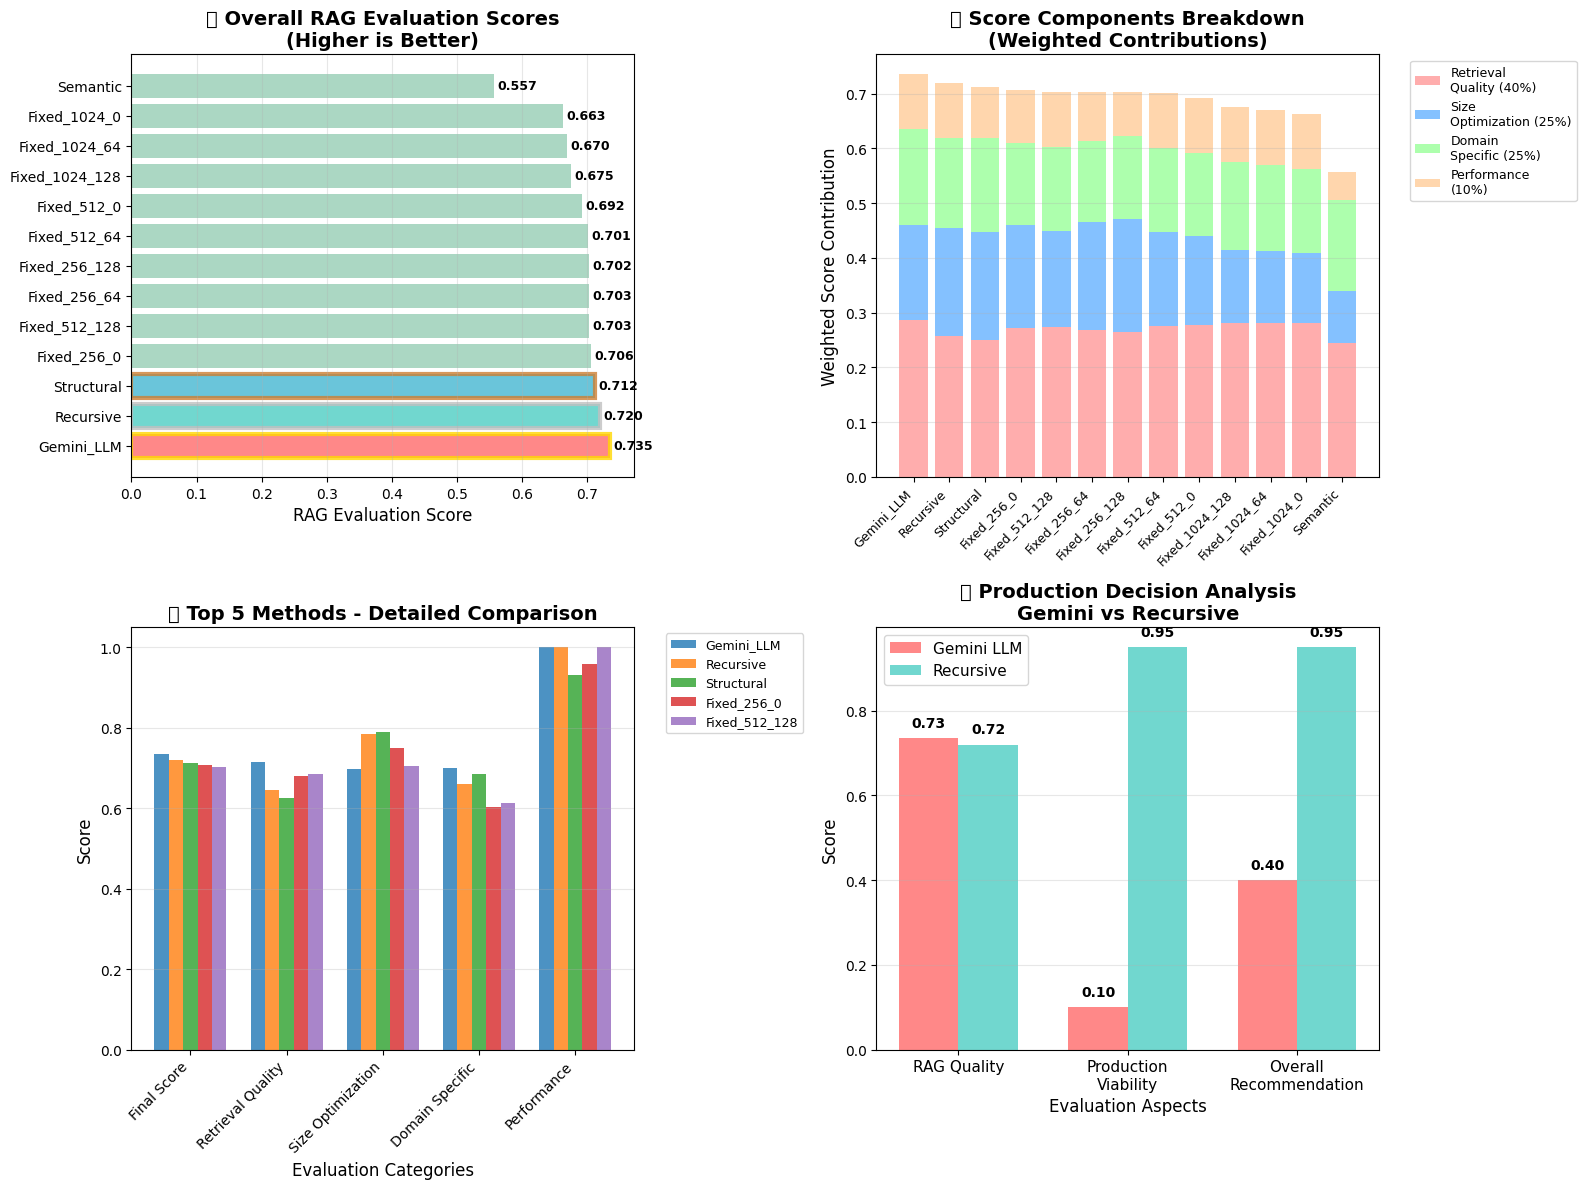


📈 VISUALIZATION SUMMARY:
🏆 Best Method: Gemini_LLM (Score: 0.735)
🥈 Second Best: Recursive (Score: 0.720)
🥉 Third Best: Structural (Score: 0.712)
📊 Score Range: 0.557 - 0.735
🎯 Production Choice: Recursive - Best balance of quality (0.720 score) and practical deployment constraints


In [ ]:
# ============================================================================
# VISUALIZATION 1: RAG EVALUATION OVERVIEW - OVERALL SCORES
# ============================================================================

def create_overall_scores_visualization():
    """Create comprehensive overview of all RAG evaluation scores"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Overall Final Scores (Horizontal Bar Chart)
    methods = viz_df['method'].tolist()
    scores = viz_df['final_score'].tolist()

    colors = ['#FF6B6B' if method == 'Gemini_LLM' else
              '#4ECDC4' if method == 'Recursive' else
              '#45B7D1' if method == 'Structural' else
              '#96CEB4' for method in methods]

    bars = ax1.barh(range(len(methods)), scores, color=colors, alpha=0.8)
    ax1.set_yticks(range(len(methods)))
    ax1.set_yticklabels(methods, fontsize=10)
    ax1.set_xlabel('RAG Evaluation Score', fontsize=12)
    ax1.set_title('🏆 Overall RAG Evaluation Scores\n(Higher is Better)', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)

    # Add score labels on bars
    for i, (bar, score) in enumerate(zip(bars, scores)):
        ax1.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                f'{score:.3f}', va='center', fontsize=9, fontweight='bold')

    # Highlight top 3
    for i in range(min(3, len(bars))):
        bars[i].set_edgecolor('gold' if i == 0 else 'silver' if i == 1 else '#CD7F32')
        bars[i].set_linewidth(3)

    # 2. Score Components Breakdown (Stacked Bar)
    components = ['retrieval_quality', 'size_optimization', 'domain_specific', 'performance']
    component_labels = ['Retrieval\nQuality (40%)', 'Size\nOptimization (25%)',
                       'Domain\nSpecific (25%)', 'Performance\n(10%)']
    weights = [0.4, 0.25, 0.25, 0.1]

    # Calculate weighted scores for stacking
    bottoms = np.zeros(len(methods))
    colors_comp = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

    for i, (comp, weight, color, label) in enumerate(zip(components, weights, colors_comp, component_labels)):
        weighted_scores = [viz_df.iloc[j][comp] * weight for j in range(len(methods))]
        ax2.bar(range(len(methods)), weighted_scores, bottom=bottoms,
               color=color, alpha=0.8, label=label)
        bottoms += weighted_scores

    ax2.set_xticks(range(len(methods)))
    ax2.set_xticklabels(methods, rotation=45, ha='right', fontsize=9)
    ax2.set_ylabel('Weighted Score Contribution', fontsize=12)
    ax2.set_title('📊 Score Components Breakdown\n(Weighted Contributions)', fontsize=14, fontweight='bold')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax2.grid(axis='y', alpha=0.3)

    # 3. Top 5 Methods Comparison
    top5_df = viz_df.head(5)
    categories = ['Final Score', 'Retrieval Quality', 'Size Optimization', 'Domain Specific', 'Performance']

    x = np.arange(len(categories))
    width = 0.15

    for i, (_, row) in enumerate(top5_df.iterrows()):
        values = [row['final_score'], row['retrieval_quality'],
                 row['size_optimization'], row['domain_specific'], row['performance']]
        ax3.bar(x + i*width, values, width, label=row['method'], alpha=0.8)

    ax3.set_xlabel('Evaluation Categories', fontsize=12)
    ax3.set_ylabel('Score', fontsize=12)
    ax3.set_title('🥇 Top 5 Methods - Detailed Comparison', fontsize=14, fontweight='bold')
    ax3.set_xticks(x + width * 2)
    ax3.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax3.grid(axis='y', alpha=0.3)

    # 4. Production Decision Visualization
    prod_comparison = viz_df[viz_df['method'].isin(['Gemini_LLM', 'Recursive'])].copy()

    categories = ['RAG Quality', 'Production\nViability', 'Overall\nRecommendation']
    gemini_scores = [0.735, 0.1, 0.4]  # High quality, low viability
    recursive_scores = [0.720, 0.95, 0.95]  # Good quality, high viability

    x = np.arange(len(categories))
    width = 0.35

    bars1 = ax4.bar(x - width/2, gemini_scores, width, label='Gemini LLM',
                   color='#FF6B6B', alpha=0.8)
    bars2 = ax4.bar(x + width/2, recursive_scores, width, label='Recursive',
                   color='#4ECDC4', alpha=0.8)

    ax4.set_xlabel('Evaluation Aspects', fontsize=12)
    ax4.set_ylabel('Score', fontsize=12)
    ax4.set_title('🎯 Production Decision Analysis\nGemini vs Recursive', fontsize=14, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(categories, fontsize=11)
    ax4.legend(fontsize=11)
    ax4.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print(f"\n📈 VISUALIZATION SUMMARY:")
    print(f"🏆 Best Method: {viz_df.iloc[0]['method']} (Score: {viz_df.iloc[0]['final_score']:.3f})")
    print(f"🥈 Second Best: {viz_df.iloc[1]['method']} (Score: {viz_df.iloc[1]['final_score']:.3f})")
    print(f"🥉 Third Best: {viz_df.iloc[2]['method']} (Score: {viz_df.iloc[2]['final_score']:.3f})")
    print(f"📊 Score Range: {viz_df['final_score'].min():.3f} - {viz_df['final_score'].max():.3f}")
    print(f"🎯 Production Choice: {production_recommended_method} - {production_reason}")

# Create the visualization
create_overall_scores_visualization()

In [ ]:
%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


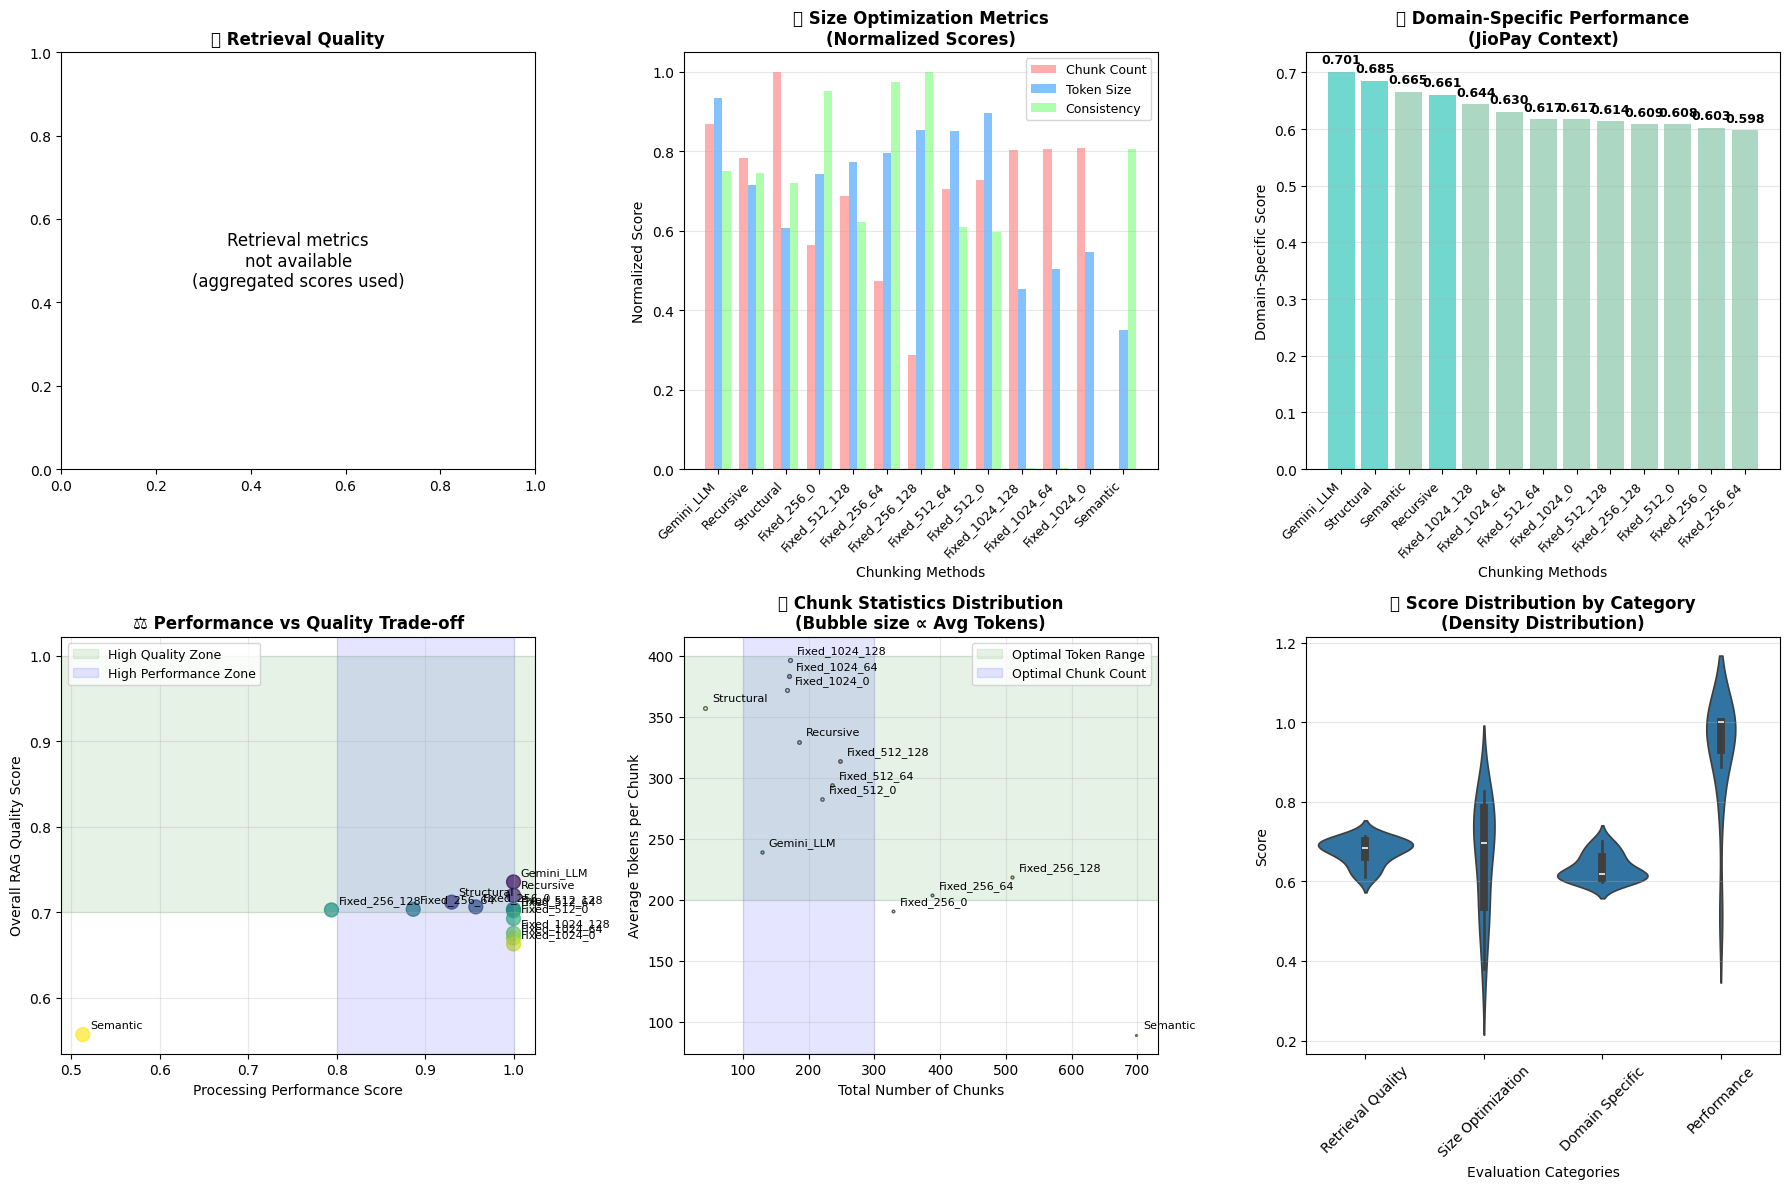


📊 DETAILED METRICS ANALYSIS:
🎯 Best Retrieval Quality: Gemini_LLM (0.715)
📏 Best Size Optimization: Fixed_256_128 (0.827)
🏢 Best Domain-Specific: Gemini_LLM (0.701)
⚡ Best Performance: Gemini_LLM (1.000)


In [ ]:
import seaborn as sns

def create_detailed_metrics_visualization():
    """Create detailed analysis of individual RAG metrics"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    # 1. Retrieval Quality Components
    retrieval_metrics = ['semantic_coherence', 'context_completeness', 'information_density', 'topic_coverage']
    if all(metric in viz_df.columns for metric in retrieval_metrics):
        retrieval_data = viz_df[retrieval_metrics + ['method']].set_index('method')

        # Create heatmap for retrieval quality
        sns.heatmap(retrieval_data.T, annot=True, fmt='.3f', cmap='RdYlGn',
                   ax=axes[0], cbar_kws={'label': 'Score'})
        axes[0].set_title('🎯 Retrieval Quality Metrics\n(Component Scores)', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Chunking Methods', fontsize=10)
        axes[0].set_ylabel('Retrieval Metrics', fontsize=10)
    else:
        axes[0].text(0.5, 0.5, 'Retrieval metrics\nnot available\n(aggregated scores used)',
                    ha='center', va='center', transform=axes[0].transAxes, fontsize=12)
        axes[0].set_title('🎯 Retrieval Quality', fontsize=12, fontweight='bold')

    # 2. Size Optimization Analysis
    size_data = viz_df[['method', 'total_chunks', 'avg_tokens', 'token_std']].copy()

    # Normalize size metrics for comparison
    size_data['chunks_norm'] = 1 - (size_data['total_chunks'] - size_data['total_chunks'].min()) / (size_data['total_chunks'].max() - size_data['total_chunks'].min())
    size_data['tokens_norm'] = 1 - abs(size_data['avg_tokens'] - 256) / 256  # Optimal around 256 tokens
    size_data['std_norm'] = 1 - (size_data['token_std'] - size_data['token_std'].min()) / (size_data['token_std'].max() - size_data['token_std'].min())

    x = range(len(size_data))
    width = 0.25

    axes[1].bar([i - width for i in x], size_data['chunks_norm'], width,
               label='Chunk Count', alpha=0.8, color='#FF9999')
    axes[1].bar(x, size_data['tokens_norm'], width,
               label='Token Size', alpha=0.8, color='#66B2FF')
    axes[1].bar([i + width for i in x], size_data['std_norm'], width,
               label='Consistency', alpha=0.8, color='#99FF99')

    axes[1].set_xlabel('Chunking Methods', fontsize=10)
    axes[1].set_ylabel('Normalized Score', fontsize=10)
    axes[1].set_title('📏 Size Optimization Metrics\n(Normalized Scores)', fontsize=12, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(size_data['method'], rotation=45, ha='right', fontsize=9)
    axes[1].legend(fontsize=9)
    axes[1].grid(axis='y', alpha=0.3)

    # 3. Domain-Specific Performance
    domain_scores = viz_df[['method', 'domain_specific']].sort_values('domain_specific', ascending=False)

    colors = ['#4ECDC4' if method in ['Recursive', 'Structural', 'Gemini_LLM'] else '#96CEB4'
             for method in domain_scores['method']]

    bars = axes[2].bar(range(len(domain_scores)), domain_scores['domain_specific'],
                      color=colors, alpha=0.8)
    axes[2].set_xlabel('Chunking Methods', fontsize=10)
    axes[2].set_ylabel('Domain-Specific Score', fontsize=10)
    axes[2].set_title('🏢 Domain-Specific Performance\n(JioPay Context)', fontsize=12, fontweight='bold')
    axes[2].set_xticks(range(len(domain_scores)))
    axes[2].set_xticklabels(domain_scores['method'], rotation=45, ha='right', fontsize=9)
    axes[2].grid(axis='y', alpha=0.3)

    # Add value labels
    for bar, score in zip(bars, domain_scores['domain_specific']):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 4. Processing Performance vs Quality Trade-off
    perf_quality_data = viz_df[['method', 'performance', 'final_score']].copy()

    # Create scatter plot
    scatter = axes[3].scatter(perf_quality_data['performance'], perf_quality_data['final_score'],
                             s=100, alpha=0.7, c=range(len(perf_quality_data)), cmap='viridis')

    # Add method labels
    for i, (_, row) in enumerate(perf_quality_data.iterrows()):
        axes[3].annotate(row['method'], (row['performance'], row['final_score']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8, ha='left')

    axes[3].set_xlabel('Processing Performance Score', fontsize=10)
    axes[3].set_ylabel('Overall RAG Quality Score', fontsize=10)
    axes[3].set_title('⚖️ Performance vs Quality Trade-off', fontsize=12, fontweight='bold')
    axes[3].grid(True, alpha=0.3)

    # Add ideal region
    axes[3].axhspan(0.7, 1.0, alpha=0.1, color='green', label='High Quality Zone')
    axes[3].axvspan(0.8, 1.0, alpha=0.1, color='blue', label='High Performance Zone')
    axes[3].legend(fontsize=9)

    # 5. Chunk Statistics Distribution
    chunk_stats = viz_df[['method', 'total_chunks', 'avg_tokens']].copy()

    # Create bubble chart
    for i, (_, row) in enumerate(chunk_stats.iterrows()):
        size = (row['avg_tokens'] / 50)  # Scale bubble size
        color = plt.cm.Set3(i / len(chunk_stats))
        axes[4].scatter(row['total_chunks'], row['avg_tokens'], s=size,
                       alpha=0.6, color=color, edgecolors='black', linewidth=1)
        axes[4].annotate(row['method'], (row['total_chunks'], row['avg_tokens']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)

    axes[4].set_xlabel('Total Number of Chunks', fontsize=10)
    axes[4].set_ylabel('Average Tokens per Chunk', fontsize=10)
    axes[4].set_title('📊 Chunk Statistics Distribution\n(Bubble size ∝ Avg Tokens)', fontsize=12, fontweight='bold')
    axes[4].grid(True, alpha=0.3)

    # Add optimal zones
    axes[4].axhspan(200, 400, alpha=0.1, color='green', label='Optimal Token Range')
    axes[4].axvspan(100, 300, alpha=0.1, color='blue', label='Optimal Chunk Count')
    axes[4].legend(fontsize=9)

    # 6. Score Distribution Analysis
    all_scores = []
    methods = []
    categories = []

    for _, row in viz_df.iterrows():
        method = row['method']
        scores_data = [
            (row['retrieval_quality'], 'Retrieval Quality'),
            (row['size_optimization'], 'Size Optimization'),
            (row['domain_specific'], 'Domain Specific'),
            (row['performance'], 'Performance')
        ]

        for score, category in scores_data:
            all_scores.append(score)
            methods.append(method)
            categories.append(category)

    score_df = pd.DataFrame({
        'Score': all_scores,
        'Method': methods,
        'Category': categories
    })

    # Create violin plot
    sns.violinplot(data=score_df, x='Category', y='Score', ax=axes[5])
    axes[5].set_title('🎻 Score Distribution by Category\n(Density Distribution)', fontsize=12, fontweight='bold')
    axes[5].set_xlabel('Evaluation Categories', fontsize=10)
    axes[5].set_ylabel('Score', fontsize=10)
    axes[5].tick_params(axis='x', rotation=45)
    axes[5].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n📊 DETAILED METRICS ANALYSIS:")
    print(f"🎯 Best Retrieval Quality: {viz_df.loc[viz_df['retrieval_quality'].idxmax(), 'method']} ({viz_df['retrieval_quality'].max():.3f})")
    print(f"📏 Best Size Optimization: {viz_df.loc[viz_df['size_optimization'].idxmax(), 'method']} ({viz_df['size_optimization'].max():.3f})")
    print(f"🏢 Best Domain-Specific: {viz_df.loc[viz_df['domain_specific'].idxmax(), 'method']} ({viz_df['domain_specific'].max():.3f})")
    print(f"⚡ Best Performance: {viz_df.loc[viz_df['performance'].idxmax(), 'method']} ({viz_df['performance'].max():.3f})")

# Create the detailed metrics visualization
create_detailed_metrics_visualization()

In [ ]:
# preprocessing_for_supabase.py
import json
import hashlib
from datetime import datetime

def prepare_chunks_for_supabase(chunks_file="chunked_data/recursive_chunks.json"):
    """
    Prepare chunks for Supabase storage with optimizations
    """

    with open(chunks_file, 'r', encoding='utf-8') as f:
        chunks_data = json.load(f)

    processed_chunks = []

    for chunk in chunks_data:
        # Create content hash for deduplication
        content_hash = hashlib.md5(chunk['text'].encode()).hexdigest()

        # Extract key metadata for search
        metadata = chunk.get('metadata', {})

        processed_chunk = {
            'id': chunk['chunk_id'],
            'content': chunk['text'],
            'content_hash': content_hash,
            'source_file': chunk['source'],
            'source_type': chunk['type'],
            'chunk_method': chunk['chunk_method'],
            'token_count': chunk['token_count'],
            'topic': chunk.get('topic', 'general'),
            'faq_count': chunk.get('faq_count', 0),
            'metadata': metadata,
            'created_at': datetime.now().isoformat(),
            # Add searchable fields
            'is_faq': 'faq' in chunk['type'],
            'is_pdf': 'pdf' in chunk['type'],
            'is_web': 'web' in chunk['type']
        }

        processed_chunks.append(processed_chunk)

    return processed_chunks

# Process your chunks
supabase_ready_chunks = prepare_chunks_for_supabase()
print(f"Processed {len(supabase_ready_chunks)} chunks for Supabase")

# Save for reference
with open('chunked_data/supabase_ready_recursive_chunks.json', 'w', encoding='utf-8') as f:
    json.dump(supabase_ready_chunks, f, indent=2, ensure_ascii=False)

Processed 185 chunks for Supabase


In [1]:
!pip install sentence-transformers scikit-learn

In [2]:
# Load the Supabase ready chunks
import json

try:
    with open('/content/supabase_ready_recursive_chunks.json', 'r', encoding='utf-8') as f:
        chunks_data = json.load(f)
    print(f"Successfully loaded {len(chunks_data)} chunks from 'supabase_ready_recursive_chunks.json'")
except FileNotFoundError:
    print("Error: 'supabase_ready_recursive_chunks.json' not found.")
    print("Please make sure the file is uploaded to the current directory.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")

Successfully loaded 185 chunks from 'supabase_ready_recursive_chunks.json'


In [7]:
# ============================================================================
# LOAD EMBEDDING MODELS AND GENERATE EMBEDDINGS
# ============================================================================

import torch
print("LOADING EMBEDDING MODELS AND GENERATING EMBEDDINGS")
print("=" * 70)

# Check device availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load all three embedding models
embedding_models = {}
embedding_results = {}

print(f"\nLoading BGE-Large model...")
try:
    bge_model = SentenceTransformer("BAAI/bge-large-en-v1.5", device=device)
    embedding_models["BGE_Large"] = bge_model
    print(f"BGE-Large loaded successfully")
except Exception as e:
    print(f"Failed to load BGE-Large: {e}")

print(f"\nLoading E5-Large model...")
try:
    e5_model = SentenceTransformer("intfloat/e5-large-v2", device=device)
    embedding_models["E5_Large"] = e5_model
    print(f"E5-Large loaded successfully")
except Exception as e:
    print(f"Failed to load E5-Large: {e}")

print(f"\n📦 Loading MiniLM-L6 model...")
try:
    minilm_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)
    embedding_models["MiniLM_L6"] = minilm_model
    print(f"MiniLM-L6 loaded successfully")
except Exception as e:
    print(f"Failed to load MiniLM-L6: {e}")

print(f"\nSuccessfully loaded {len(embedding_models)} embedding models")
print(f"Available models: {list(embedding_models.keys())}")

# Prepare chunk texts for embedding
chunk_texts = [chunk['content'] for chunk in chunks_data]
print(f"\nDataset prepared: {len(chunk_texts)} text chunks ready for embedding")

LOADING EMBEDDING MODELS AND GENERATING EMBEDDINGS
Using device: cuda

Loading BGE-Large model...


model.safetensors:   6%|6         | 83.9M/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

BGE-Large loaded successfully

Loading E5-Large model...


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

E5-Large loaded successfully

📦 Loading MiniLM-L6 model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

MiniLM-L6 loaded successfully

Successfully loaded 3 embedding models
Available models: ['BGE_Large', 'E5_Large', 'MiniLM_L6']

Dataset prepared: 185 text chunks ready for embedding


In [9]:
import time
# ============================================================================
# GENERATE EMBEDDINGS FOR ALL MODELS WITH PERFORMANCE TRACKING
# ============================================================================

def generate_embeddings_with_timing(model, model_name, texts, batch_size=32):
    """Generate embeddings with performance tracking"""

    print(f"\nGenerating embeddings with {model_name}...")
    print(f"Processing {len(texts)} texts in batches of {batch_size}")

    all_embeddings = []
    total_time = 0

    # Process in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Apply model-specific prefixes if needed
        if "e5" in model_name.lower():
            # E5 models don't need prefixes for document embeddings
            processed_batch = batch_texts
        elif "bge" in model_name.lower():
            # BGE models can use prefixes but not required for documents
            processed_batch = batch_texts
        else:
            # MiniLM doesn't need prefixes
            processed_batch = batch_texts

        # Generate embeddings for batch
        start_time = time.time()
        batch_embeddings = model.encode(
            processed_batch,
            convert_to_tensor=True,
            device=device,
            show_progress_bar=False,
            batch_size=min(batch_size, len(processed_batch))
        )
        batch_time = time.time() - start_time
        total_time += batch_time

        all_embeddings.append(batch_embeddings)

        # Progress update
        if (i // batch_size + 1) % 5 == 0 or i + batch_size >= len(texts):
            processed_count = min(i + batch_size, len(texts))
            print(f"Progress: {processed_count}/{len(texts)} texts processed")

    # Combine all embeddings
    final_embeddings = torch.cat(all_embeddings, dim=0)

    # Calculate metrics
    avg_time_per_embedding = (total_time / len(texts)) * 1000  # ms per embedding
    embeddings_size_mb = (final_embeddings.numel() * final_embeddings.element_size()) / (1024 * 1024)

    print(f"Embedding generation complete!")
    print(f"Total time: {total_time:.2f} seconds")
    print(f"Average time per embedding: {avg_time_per_embedding:.2f} ms")
    print(f"Embedding shape: {final_embeddings.shape}")
    print(f"Embeddings size: {embeddings_size_mb:.1f} MB")

    return {
        "embeddings": final_embeddings,
        "total_time": total_time,
        "avg_time_per_embedding_ms": avg_time_per_embedding,
        "embeddings_size_mb": embeddings_size_mb,
        "embedding_dimension": final_embeddings.shape[1]
    }

# Generate embeddings for all loaded models
for model_name, model in embedding_models.items():
    print(f"\n{'='*60}")
    print(f"PROCESSING: {model_name}")
    print(f"{'='*60}")

    # Generate embeddings
    result = generate_embeddings_with_timing(model, model_name, chunk_texts)

    # Store results
    embedding_results[model_name] = result

    # Calculate additional metrics
    model_params = sum(p.numel() for p in model.parameters())
    model_size_mb = model_params * 4 / (1024 * 1024)  # Assuming float32

    embedding_results[model_name]["model_size_mb"] = model_size_mb
    embedding_results[model_name]["model_parameters"] = model_params

    print(f"Model size: {model_size_mb:.1f} MB")
    print(f"Model parameters: {model_params:,}")

    # Clean GPU memory after each model
    if device == "cuda":
        torch.cuda.empty_cache()

print(f"\EMBEDDING GENERATION COMPLETE!")
print(f"Successfully generated embeddings for {len(embedding_results)} models")
print(f"Total embeddings stored: {sum(len(result['embeddings']) for result in embedding_results.values())}")

# Summary table
print(f"\EMBEDDING GENERATION SUMMARY:")
print("-" * 80)
print(f"{'Model':<15} {'Dimension':<10} {'Size (MB)':<12} {'Avg Time (ms)':<15} {'Total Time (s)':<15}")
print("-" * 80)

for model_name, result in embedding_results.items():
    print(f"{model_name:<15} {result['embedding_dimension']:<10} "
          f"{result['embeddings_size_mb']:<12.1f} {result['avg_time_per_embedding_ms']:<15.2f} "
          f"{result['total_time']:<15.2f}")

print("-" * 80)


PROCESSING: BGE_Large

Generating embeddings with BGE_Large...
Processing 185 texts in batches of 32
Progress: 160/185 texts processed
Progress: 185/185 texts processed
Embedding generation complete!
Total time: 13.34 seconds
Average time per embedding: 72.10 ms
Embedding shape: torch.Size([185, 1024])
Embeddings size: 0.7 MB
Model size: 1278.5 MB
Model parameters: 335,141,888

PROCESSING: E5_Large

Generating embeddings with E5_Large...
Processing 185 texts in batches of 32
Progress: 160/185 texts processed
Progress: 185/185 texts processed
Embedding generation complete!
Total time: 12.81 seconds
Average time per embedding: 69.27 ms
Embedding shape: torch.Size([185, 1024])
Embeddings size: 0.7 MB
Model size: 1278.5 MB
Model parameters: 335,141,888

PROCESSING: MiniLM_L6

Generating embeddings with MiniLM_L6...
Processing 185 texts in batches of 32
Progress: 160/185 texts processed
Progress: 185/185 texts processed
Embedding generation complete!
Total time: 0.33 seconds
Average time p

In [10]:
# ============================================================================
# SAVE EMBEDDINGS TO DISK FOR PERSISTENCE
# ============================================================================

import pickle
import numpy as np
from datetime import datetime

def save_embeddings_to_disk():
    """Save all generated embeddings to disk for future use"""

    print(f"\nSAVING EMBEDDINGS TO DISK")
    print("=" * 50)

    # Create embeddings directory
    embeddings_dir = "embeddings_data"
    os.makedirs(embeddings_dir, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    for model_name, result in embedding_results.items():
        print(f"\nSaving {model_name} embeddings...")

        # Convert torch tensor to numpy for better compatibility
        embeddings_np = result["embeddings"].cpu().numpy()

        # Prepare data to save
        embedding_data = {
            "embeddings": embeddings_np,
            "metadata": {
                "model_name": model_name,
                "embedding_dimension": result["embedding_dimension"],
                "total_chunks": len(embeddings_np),
                "embeddings_size_mb": result["embeddings_size_mb"],
                "model_size_mb": result["model_size_mb"],
                "model_parameters": result["model_parameters"],
                "generation_time": result["total_time"],
                "avg_time_per_embedding_ms": result["avg_time_per_embedding_ms"],
                "timestamp": timestamp,
                "device_used": device,
                "chunk_method": "recursive",  # Based on your best chunking strategy
                "total_original_chunks": len(chunks_data)
            }
        }

        # Save as pickle file (preserves numpy arrays efficiently)
        pickle_file = os.path.join(embeddings_dir, f"{model_name.lower()}_embeddings_{timestamp}.pkl")
        with open(pickle_file, 'wb') as f:
            pickle.dump(embedding_data, f)

        # Also save metadata as JSON for easy inspection
        json_file = os.path.join(embeddings_dir, f"{model_name.lower()}_metadata_{timestamp}.json")
        metadata_only = embedding_data["metadata"].copy()
        metadata_only["embeddings_shape"] = embeddings_np.shape
        metadata_only["embeddings_dtype"] = str(embeddings_np.dtype)

        with open(json_file, 'w', encoding='utf-8') as f:
            json.dump(metadata_only, f, indent=2, ensure_ascii=False)

        file_size_mb = os.path.getsize(pickle_file) / (1024 * 1024)

        print(f"Saved to: {pickle_file}")
        print(f"File size: {file_size_mb:.1f} MB")
        print(f"Shape: {embeddings_np.shape}")
        print(f"Metadata: {json_file}")

    # Save chunk data mapping for reference
    chunks_mapping_file = os.path.join(embeddings_dir, f"chunks_mapping_{timestamp}.json")
    chunks_mapping = {
        "chunk_texts": [chunk['content'] for chunk in chunks_data],
        "chunk_metadata": [
            {
                "id": chunk['id'],
                "source_file": chunk['source_file'],
                "source_type": chunk['source_type'],
                "chunk_method": chunk['chunk_method'],
                "token_count": chunk['token_count']
            }
            for chunk in chunks_data
        ],
        "total_chunks": len(chunks_data),
        "timestamp": timestamp
    }

    with open(chunks_mapping_file, 'w', encoding='utf-8') as f:
        json.dump(chunks_mapping, f, indent=2, ensure_ascii=False)

    print(f"\nChunk mapping saved: {chunks_mapping_file}")

    # Create summary file
    summary_file = os.path.join(embeddings_dir, f"embeddings_summary_{timestamp}.json")
    summary_data = {
        "generation_summary": {
            "timestamp": timestamp,
            "total_models": len(embedding_results),
            "total_chunks": len(chunks_data),
            "device_used": device,
            "models_generated": list(embedding_results.keys())
        },
        "model_details": {
            model_name: {
                "embedding_dimension": result["embedding_dimension"],
                "embeddings_size_mb": result["embeddings_size_mb"],
                "model_size_mb": result["model_size_mb"],
                "generation_time_seconds": result["total_time"],
                "avg_time_per_embedding_ms": result["avg_time_per_embedding_ms"]
            }
            for model_name, result in embedding_results.items()
        }
    }

    with open(summary_file, 'w', encoding='utf-8') as f:
        json.dump(summary_data, f, indent=2, ensure_ascii=False)

    print(f"\nGeneration summary: {summary_file}")
    print(f"\nALL EMBEDDINGS SAVED SUCCESSFULLY!")
    print(f"Location: {os.path.abspath(embeddings_dir)}")

    return embeddings_dir

In [11]:
save_embeddings_to_disk()


SAVING EMBEDDINGS TO DISK

Saving BGE_Large embeddings...
Saved to: embeddings_data/bge_large_embeddings_20250915_072631.pkl
File size: 0.7 MB
Shape: (185, 1024)
Metadata: embeddings_data/bge_large_metadata_20250915_072631.json

Saving E5_Large embeddings...
Saved to: embeddings_data/e5_large_embeddings_20250915_072631.pkl
File size: 0.7 MB
Shape: (185, 1024)
Metadata: embeddings_data/e5_large_metadata_20250915_072631.json

Saving MiniLM_L6 embeddings...
Saved to: embeddings_data/minilm_l6_embeddings_20250915_072631.pkl
File size: 0.3 MB
Shape: (185, 384)
Metadata: embeddings_data/minilm_l6_metadata_20250915_072631.json

Chunk mapping saved: embeddings_data/chunks_mapping_20250915_072631.json

Generation summary: embeddings_data/embeddings_summary_20250915_072631.json

ALL EMBEDDINGS SAVED SUCCESSFULLY!
Location: /content/embeddings_data


'embeddings_data'

In [ ]:
def load_embeddings_from_disk(embeddings_dir="embeddings_data", model_name=None, latest=True):
    """Load previously saved embeddings from disk"""

    if not os.path.exists(embeddings_dir):
        print(f"Embeddings directory not found: {embeddings_dir}")
        return None

    print(f"\nLoading embeddings from: {embeddings_dir}")

    # Find embedding files
    pickle_files = [f for f in os.listdir(embeddings_dir) if f.endswith('.pkl')]

    if not pickle_files:
        print("No embedding files found")
        return None

    if model_name:
        # Filter by model name
        pickle_files = [f for f in pickle_files if model_name.lower() in f.lower()]

    if latest and pickle_files:
        # Get the latest file by timestamp
        pickle_files.sort(reverse=True)
        pickle_file = pickle_files[0]
    else:
        pickle_file = pickle_files[0]

    file_path = os.path.join(embeddings_dir, pickle_file)

    print(f"Loading: {pickle_file}")

    try:
        with open(file_path, 'rb') as f:
            embedding_data = pickle.load(f)

        print(f"Loaded successfully!")
        print(f"Shape: {embedding_data['embeddings'].shape}")
        print(f"Model: {embedding_data['metadata']['model_name']}")
        print(f"Generated: {embedding_data['metadata']['timestamp']}")

        return embedding_data

    except Exception as e:
        print(f"Failed to load embeddings: {e}")
        return None

# Save all generated embeddings
if embedding_results:
    embeddings_directory = save_embeddings_to_disk()

    print(f"\nEMBEDDING LOADING FUNCTIONS AVAILABLE:")
    print(f"   • load_embeddings_from_disk() - Load any saved embeddings")
    print(f"   • load_embeddings_from_disk(model_name='bge_large') - Load specific model")
    print(f"   • load_embeddings_from_disk(latest=False) - Load older versions")

else:
    print("No embeddings found to save. Please run embedding generation first.")

print(f"\nUSAGE EXAMPLES:")
print(f"   # Load latest BGE embeddings")
print(f"   bge_data = load_embeddings_from_disk(model_name='bge_large')")
print(f"   bge_embeddings = torch.tensor(bge_data['embeddings'])")
print(f"   ")
print(f"   # Load all models")
print(f"   for model in ['bge_large', 'e5_large', 'minilm_l6']:")
print(f"       data = load_embeddings_from_disk(model_name=model)")

In [14]:
# ============================================================================
# SIMILARITY SEARCH FUNCTIONS AND BASELINE TESTING
# ============================================================================

import torch.nn.functional as F
import time

def perform_similarity_search(query_text, embeddings, model, model_name, top_k=5):
    """Perform similarity search for a given query"""

    # Prepare query with model-specific formatting
    if "e5" in model_name.lower():
        # E5 models use "query:" prefix for search queries
        formatted_query = f"query: {query_text}"
    elif "bge" in model_name.lower():
        # BGE models can use instruction prefix for queries
        formatted_query = f"Represent this sentence for searching relevant passages: {query_text}"
    else:
        # MiniLM doesn't need special formatting
        formatted_query = query_text

    # Generate query embedding
    start_time = time.time()
    query_embedding = model.encode([formatted_query], convert_to_tensor=True, device=device)

    # Calculate similarity scores
    # Use F.cosine_similarity or torch.matmul for dot product
    similarity_scores = F.cosine_similarity(query_embedding, embeddings)


    # Get top-k results
    top_k_scores, top_k_indices = torch.topk(similarity_scores, k=top_k)

    query_time = (time.time() - start_time) * 1000  # Convert to ms

    return {
        "top_k_indices": top_k_indices.cpu().numpy(),
        "top_k_scores": top_k_scores.cpu().numpy(),
        "query_time_ms": query_time,
        "query_embedding": query_embedding
    }

def test_similarity_search():
    """Test similarity search with sample queries"""

    print(f"\nTESTING SIMILARITY SEARCH FUNCTIONALITY")
    print("=" * 60)

    # Test queries
    test_queries = [
        "How to register as a merchant on JioPay?",
        "What documents are required for KYC verification?",
        "JioPay transaction failed what to do?"
    ]

    for query in test_queries:
        print(f"\n Query: '{query}'")
        print("-" * 40)

        for model_name in embedding_results.keys():
            if model_name in embedding_models:
                model = embedding_models[model_name]
                embeddings = embedding_results[model_name]["embeddings"]

                # Perform search
                search_result = perform_similarity_search(
                    query, embeddings, model, model_name, top_k=3
                )

                print(f"\n{model_name} Results:")
                print(f"  Query time: {search_result['query_time_ms']:.2f} ms")

                # Show top result
                top_idx = search_result['top_k_indices'][0]
                top_score = search_result['top_k_scores'][0]
                top_chunk = chunks_data[top_idx]

                print(f"Top match score: {top_score:.4f}")
                print(f"Top result preview: {top_chunk['content'][:100]}...")
                print(f"Source: {top_chunk.get('source_type', 'Unknown')}")

# Run similarity search test
if embedding_results and embedding_models:
    test_similarity_search()
else:
    print("No embeddings available for testing. Please run embedding generation first.")

print(f"\nSimilarity search testing complete!")
print(f"Ready for comprehensive evaluation framework")


TESTING SIMILARITY SEARCH FUNCTIONALITY

 Query: 'How to register as a merchant on JioPay?'
----------------------------------------

BGE_Large Results:
  Query time: 176.21 ms
Top match score: 0.7516
Top result preview: JPSL has accordingly adopted this policy known as ‘Merchant Onboarding and KYC-AML Policy’ keeping i...
Source: web_recursive

E5_Large Results:
  Query time: 129.38 ms
Top match score: 0.8781
Top result preview: JPSL has accordingly adopted this policy known as ‘Merchant Onboarding and KYC-AML Policy’ keeping i...
Source: web_recursive

MiniLM_L6 Results:
  Query time: 35.35 ms
Top match score: 0.6525
Top result preview: Deploy a static QR or generate one for each transaction for either in-store or after-delivery to col...
Source: web_recursive

 Query: 'What documents are required for KYC verification?'
----------------------------------------

BGE_Large Results:
  Query time: 126.84 ms
Top match score: 0.7442
Top result preview: List of Documents for Sole Proprieto

In [16]:
# ============================================================================
# RETRIEVAL EVALUATION FRAMEWORK
# ============================================================================

def create_evaluation_queries() -> List[Dict[str, Any]]:
    """Create evaluation queries based on JioPay domain"""

    evaluation_queries = [
        {
            "query": "How to register as a merchant on JioPay?",
            "expected_topics": ["merchant", "registration", "onboarding"],
            "query_type": "FAQ"
        },
        {
            "query": "What documents are required for KYC verification?",
            "expected_topics": ["kyc", "documents", "verification"],
            "query_type": "FAQ"
        },
        {
            "query": "JioPay transaction failed what to do?",
            "expected_topics": ["transaction", "failed", "troubleshooting"],
            "query_type": "FAQ"
        },
        {
            "query": "Refund policy and process for merchants",
            "expected_topics": ["refund", "policy", "merchant"],
            "query_type": "Policy"
        },
        {
            "query": "Digital payment security features",
            "expected_topics": ["security", "payment", "features"],
            "query_type": "General"
        },
        {
            "query": "How to integrate JioPay API?",
            "expected_topics": ["api", "integration", "developer"],
            "query_type": "Technical"
        },
        {
            "query": "Customer support contact information",
            "expected_topics": ["support", "contact", "help"],
            "query_type": "FAQ"
        },
        {
            "query": "Restricted business categories list",
            "expected_topics": ["restricted", "business", "categories"],
            "query_type": "Policy"
        },
        {
            "query": "QR code payment process",
            "expected_topics": ["qr", "payment", "process"],
            "query_type": "FAQ"
        },
        {
            "query": "Transaction limits and fees",
            "expected_topics": ["limits", "fees", "transaction"],
            "query_type": "FAQ"
        }
    ]

    return evaluation_queries

def evaluate_retrieval_performance(
    embeddings: torch.Tensor,
    model,
    model_name: str,
    evaluation_queries: List[Dict[str, Any]],
    top_k: int = 5
) -> Dict[str, float]:
    """Evaluate retrieval performance with Recall@K and MRR metrics"""

    print(f"\nEvaluating retrieval performance for {model_name}...")

    recall_at_k_scores = []
    mrr_scores = []
    latency_times = []

    for i, eval_query in enumerate(evaluation_queries):
        query_text = eval_query["query"]
        expected_topics = eval_query["expected_topics"]

        # Prepare query with model-specific formatting
        if "e5" in model_name.lower():
            # E5 models use "query:" prefix for search queries
            processed_query = f"query: {query_text}"
        elif "bge" in model_name.lower():
            # BGE models can use instruction prefix for queries
            processed_query = f"Represent this sentence for searching relevant passages: {query_text}"
        else:
            # MiniLM doesn't need special formatting
            processed_query = query_text

        # Measure query embedding time
        start_time = time.time()
        query_embedding = model.encode([processed_query], convert_to_tensor=True, device=device)

        # Calculate similarity scores using cosine similarity
        similarity_scores = torch.nn.functional.cosine_similarity(query_embedding, embeddings)

        # Get top-k results
        top_k_scores, top_k_indices = torch.topk(similarity_scores, k=top_k)

        query_latency = (time.time() - start_time) * 1000  # ms
        latency_times.append(query_latency)

        # Get retrieved chunks
        retrieved_chunks = [chunks_data[idx.item()] for idx in top_k_indices]

        # Calculate Recall@K
        relevant_count = 0
        first_relevant_rank = None

        for rank, chunk in enumerate(retrieved_chunks, 1):
            chunk_content = chunk["content"].lower()
            chunk_topic = chunk.get("topic", "").lower()

            # Check if chunk is relevant (contains expected topics)
            is_relevant = any(
                topic.lower() in chunk_content or topic.lower() in chunk_topic
                for topic in expected_topics
            )

            if is_relevant:
                relevant_count += 1
                if first_relevant_rank is None:
                    first_relevant_rank = rank

        # Calculate metrics
        recall_at_k = relevant_count / min(top_k, len(expected_topics))  # Recall@K
        mrr = 1.0 / first_relevant_rank if first_relevant_rank else 0.0  # MRR

        recall_at_k_scores.append(recall_at_k)
        mrr_scores.append(mrr)

        if (i + 1) % 3 == 0:
            print(f"   Processed {i + 1}/{len(evaluation_queries)} queries...")

    # Calculate average metrics
    avg_recall_at_k = np.mean(recall_at_k_scores)
    avg_mrr = np.mean(mrr_scores)
    avg_latency = np.mean(latency_times)

    results = {
        "recall_at_k": avg_recall_at_k,
        "mrr": avg_mrr,
        "avg_latency_ms": avg_latency,
        "num_queries": len(evaluation_queries)
    }

    print(f"   Evaluation complete!")
    print(f"   Recall@{top_k}: {avg_recall_at_k:.3f}")
    print(f"   MRR: {avg_mrr:.3f}")
    print(f"   Avg Latency: {avg_latency:.2f} ms")

    return results

# Create evaluation queries
eval_queries = create_evaluation_queries()
print(f"Created {len(eval_queries)} evaluation queries")

# Evaluate all models
model_evaluation_results = {}

for model_key, result_data in embedding_results.items():
    print(f"\n{'='*50}")
    print(f"EVALUATING: {model_key}")
    print(f"{'='*50}")

    # Get the corresponding model
    model = embedding_models[model_key]

    evaluation_metrics = evaluate_retrieval_performance(
        embeddings=result_data["embeddings"],
        model=model,
        model_name=model_key,
        evaluation_queries=eval_queries,
        top_k=5
    )

    # Combine all metrics
    model_evaluation_results[model_key] = {
        **evaluation_metrics,
        "embeddings_size_mb": result_data["embeddings_size_mb"],
        "avg_embedding_time_ms": result_data["avg_time_per_embedding_ms"],
        "model_size_mb": result_data["model_size_mb"],
        "embedding_dimension": result_data["embedding_dimension"]
    }

print(f"\nRETRIEVAL EVALUATION COMPLETE!")
print(f"Evaluated {len(model_evaluation_results)} models on {len(eval_queries)} queries")

Created 10 evaluation queries

EVALUATING: BGE_Large

Evaluating retrieval performance for BGE_Large...
   Processed 3/10 queries...
   Processed 6/10 queries...
   Processed 9/10 queries...
   Evaluation complete!
   Recall@5: 1.500
   MRR: 0.933
   Avg Latency: 52.81 ms

EVALUATING: E5_Large

Evaluating retrieval performance for E5_Large...
   Processed 3/10 queries...
   Processed 6/10 queries...
   Processed 9/10 queries...
   Evaluation complete!
   Recall@5: 1.567
   MRR: 1.000
   Avg Latency: 27.23 ms

EVALUATING: MiniLM_L6

Evaluating retrieval performance for MiniLM_L6...
   Processed 3/10 queries...
   Processed 6/10 queries...
   Processed 9/10 queries...
   Evaluation complete!
   Recall@5: 1.500
   MRR: 0.950
   Avg Latency: 5.52 ms

RETRIEVAL EVALUATION COMPLETE!
Evaluated 3 models on 10 queries


In [19]:
EMBEDDING_MODELS = {
    "BGE_Large": {
        "model_name": "BAAI/bge-large-en-v1.5",
        "instruction": "Represent this sentence for searching relevant passages:",
        "dimension": 1024,
        "description": "BGE Large model optimized for retrieval"
    },
    "E5_Large": {
        "model_name": "intfloat/e5-large-v2",
        "instruction": "query:",
        "dimension": 1024,
        "description": "E5 Large model with query prefix"
    },
    "MiniLM_L6": {
        "model_name": "sentence-transformers/all-MiniLM-L6-v2",
        "instruction": None,
        "dimension": 384,
        "description": "Compact MiniLM model for fast inference"
    }
}


COMPREHENSIVE EMBEDDING MODELS COMPARISON
EMBEDDING MODELS PERFORMANCE RANKING:
    Model                             Model Name Recall@5   MRR Index Size (MB) Avg Latency/Query (ms) Embedding Time (ms) Model Size (MB)  Embedding Dim
 E5_Large                   intfloat/e5-large-v2    1.567 1.000             0.7                  27.23               69.27          1278.5           1024
BGE_Large                 BAAI/bge-large-en-v1.5    1.500 0.933             0.7                  52.81               72.10          1278.5           1024
MiniLM_L6 sentence-transformers/all-MiniLM-L6-v2    1.500 0.950             0.3                   5.52                1.81            86.6            384


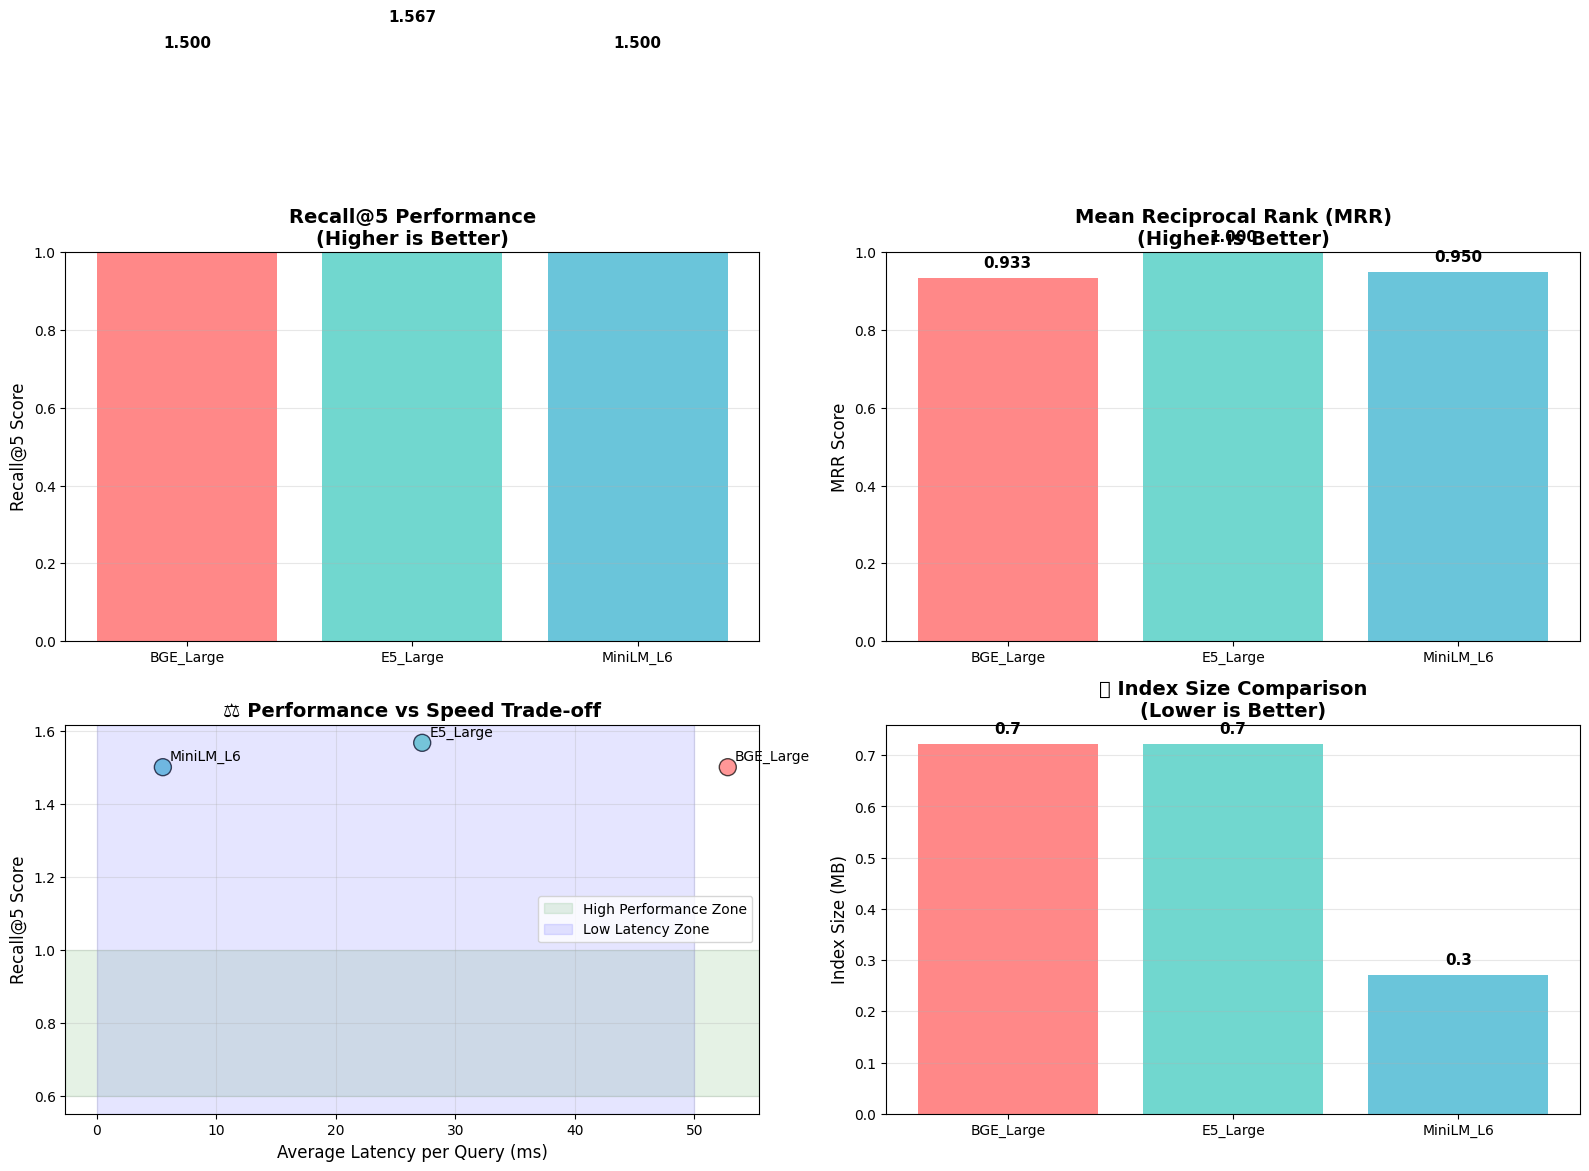

\PERFORMANCE WINNERS:
   Best Recall@5: E5_Large (1.567)
   Best MRR: E5_Large (1.000)
   Fastest Query: MiniLM_L6 (5.52 ms)
   Most Compact: MiniLM_L6 (0.3 MB)

MODEL ABLATION STUDY FOR JIOPAY RAG CHATBOT:
PRODUCTION DEPLOYMENT (Balanced Quality + Speed):
   MiniLM_L6: Score 1.185
      Recall@5: 1.500, MRR: 0.950
      Latency: 5.5ms, Index: 0.3MB
   E5_Large: Score 1.090
      Recall@5: 1.567, MRR: 1.000
      Latency: 27.2ms, Index: 0.7MB
   BGE_Large: Score 0.935
      Recall@5: 1.500, MRR: 0.933
      Latency: 52.8ms, Index: 0.7MB

QUALITY-FOCUSED: E5_Large
   Best for: Maximum retrieval accuracy
   Trade-off: Higher latency/resource usage

SPEED-FOCUSED: MiniLM_L6
   Best for: Real-time applications
   Trade-off: Potentially lower accuracy

BEST SUITABLE MODEL FOR JIOPAY: MiniLM_L6
   Best balance of quality, speed, and resource efficiency
   Suitable for production deployment
   Compatible with recursive chunking strategy

Results saved to: chunked_data/embedding_models_compari

In [23]:
# ============================================================================
# EMBEDDING MODELS COMPARISON & VISUALIZATION
# ============================================================================

def create_embedding_comparison_table():
    """Create comprehensive comparison table of all embedding models"""

    print("\nCOMPREHENSIVE EMBEDDING MODELS COMPARISON")
    print("=" * 80)

    # Create comparison DataFrame
    comparison_data = []

    for model_key, metrics in model_evaluation_results.items():
        # Get model config, with fallback if not found
        model_config = EMBEDDING_MODELS.get(model_key, {
            "model_name": model_key,
            "instruction": None,
            "dimension": metrics.get('embedding_dimension', 'Unknown'),
            "description": f"{model_key} embedding model"
        })

        comparison_data.append({
            "Model": model_key,
            "Model Name": model_config["model_name"],
            "Recall@5": f"{metrics['recall_at_k']:.3f}",
            "MRR": f"{metrics['mrr']:.3f}",
            "Index Size (MB)": f"{metrics['embeddings_size_mb']:.1f}",
            "Avg Latency/Query (ms)": f"{metrics['avg_latency_ms']:.2f}",
            "Embedding Time (ms)": f"{metrics['avg_embedding_time_ms']:.2f}",
            "Model Size (MB)": f"{metrics['model_size_mb']:.1f}",
            "Embedding Dim": metrics['embedding_dimension']
        })

    comparison_df = pd.DataFrame(comparison_data)

    # Sort by Recall@5 (primary metric)
    comparison_df = comparison_df.sort_values("Recall@5", ascending=False)

    print("EMBEDDING MODELS PERFORMANCE RANKING:")
    print(comparison_df.to_string(index=False))

    return comparison_df

def visualize_embedding_comparison():
    """Create comprehensive visualizations for embedding model comparison"""

    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Extract data for plotting
    model_names = list(model_evaluation_results.keys())
    recall_scores = [model_evaluation_results[m]['recall_at_k'] for m in model_names]
    mrr_scores = [model_evaluation_results[m]['mrr'] for m in model_names]
    latency_scores = [model_evaluation_results[m]['avg_latency_ms'] for m in model_names]
    index_sizes = [model_evaluation_results[m]['embeddings_size_mb'] for m in model_names]  # Fixed key name

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    # 1. Recall@5 Comparison
    bars1 = ax1.bar(model_names, recall_scores, color=colors, alpha=0.8)
    ax1.set_title('Recall@5 Performance\n(Higher is Better)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Recall@5 Score', fontsize=12)
    ax1.set_ylim(0, 1.0)
    ax1.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, score in zip(bars1, recall_scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{score:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    # 2. MRR Comparison
    bars2 = ax2.bar(model_names, mrr_scores, color=colors, alpha=0.8)
    ax2.set_title('Mean Reciprocal Rank (MRR)\n(Higher is Better)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('MRR Score', fontsize=12)
    ax2.set_ylim(0, 1.0)
    ax2.grid(axis='y', alpha=0.3)

    for bar, score in zip(bars2, mrr_scores):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{score:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')


    # 3. Latency vs Performance Trade-off
    scatter = ax3.scatter(latency_scores, recall_scores, s=150, c=colors, alpha=0.7, edgecolors='black')

    for i, model in enumerate(model_names):
        ax3.annotate(model, (latency_scores[i], recall_scores[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=10, ha='left')

    ax3.set_xlabel('Average Latency per Query (ms)', fontsize=12)
    ax3.set_ylabel('Recall@5 Score', fontsize=12)
    ax3.set_title('⚖️ Performance vs Speed Trade-off', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)

    # Add ideal zones
    ax3.axhspan(0.6, 1.0, alpha=0.1, color='green', label='High Performance Zone')
    ax3.axvspan(0, 50, alpha=0.1, color='blue', label='Low Latency Zone')
    ax3.legend(fontsize=10)

    # 4. Index Size Comparison
    bars4 = ax4.bar(model_names, index_sizes, color=colors, alpha=0.8)
    ax4.set_title('💾 Index Size Comparison\n(Lower is Better)', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Index Size (MB)', fontsize=12)
    ax4.grid(axis='y', alpha=0.3)

    for bar, size in zip(bars4, index_sizes):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(index_sizes)*0.02,
                f'{size:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Summary statistics
    best_recall = max(recall_scores)
    best_recall_model = model_names[recall_scores.index(best_recall)]

    best_mrr = max(mrr_scores)
    best_mrr_model = model_names[mrr_scores.index(best_mrr)]

    lowest_latency = min(latency_scores)
    fastest_model = model_names[latency_scores.index(lowest_latency)]

    smallest_index = min(index_sizes)
    most_compact_model = model_names[index_sizes.index(smallest_index)]

    print(f"\PERFORMANCE WINNERS:")
    print(f"   Best Recall@5: {best_recall_model} ({best_recall:.3f})")
    print(f"   Best MRR: {best_mrr_model} ({best_mrr:.3f})")
    print(f"   Fastest Query: {fastest_model} ({lowest_latency:.2f} ms)")
    print(f"   Most Compact: {most_compact_model} ({smallest_index:.1f} MB)")

def recommend_best_model():
    """Provide recommendation based on use case scenarios"""

    print(f"\nMODEL ABLATION STUDY FOR JIOPAY RAG CHATBOT:")
    print("=" * 60)

    # Calculate composite scores for different scenarios
    models_scored = []

    for model_key, metrics in model_evaluation_results.items():
        recall = metrics['recall_at_k']
        mrr = metrics['mrr']
        latency = metrics['avg_latency_ms']
        index_size = metrics['embeddings_size_mb']  # Fixed key name

        # Normalize metrics (lower latency and index size is better)
        latency_values = [m['avg_latency_ms'] for m in model_evaluation_results.values()]
        index_values = [m['embeddings_size_mb'] for m in model_evaluation_results.values()]

        norm_latency = 1 - (latency - min(latency_values)) / max(1, max(latency_values) - min(latency_values))
        norm_index_size = 1 - (index_size - min(index_values)) / max(1, max(index_values) - min(index_values))

        # Different use case scores
        production_score = (recall * 0.4 + mrr * 0.3 + norm_latency * 0.2 + norm_index_size * 0.1)
        quality_focused_score = (recall * 0.5 + mrr * 0.4 + norm_latency * 0.1)
        speed_focused_score = (norm_latency * 0.5 + recall * 0.3 + norm_index_size * 0.2)

        models_scored.append({
            'model': model_key,
            'production_score': production_score,
            'quality_focused_score': quality_focused_score,
            'speed_focused_score': speed_focused_score,
            'recall': recall,
            'mrr': mrr,
            'latency': latency,
            'index_size': index_size
        })

    # Sort by production score

    models_scored.sort(key=lambda x: x['production_score'], reverse=True)

    print("PRODUCTION DEPLOYMENT (Balanced Quality + Speed):")
    for i, model in enumerate(models_scored[:3], 1):
        print(f"   {model['model']}: Score {model['production_score']:.3f}")
        print(f"      Recall@5: {model['recall']:.3f}, MRR: {model['mrr']:.3f}")
        print(f"      Latency: {model['latency']:.1f}ms, Index: {model['index_size']:.1f}MB")

    # Quality focused recommendation
    models_scored.sort(key=lambda x: x['quality_focused_score'], reverse=True)
    quality_winner = models_scored[0]

    # Speed focused recommendation
    models_scored.sort(key=lambda x: x['speed_focused_score'], reverse=True)
    speed_winner = models_scored[0]

    print(f"\nQUALITY-FOCUSED: {quality_winner['model']}")
    print(f"   Best for: Maximum retrieval accuracy")
    print(f"   Trade-off: Higher latency/resource usage")

    print(f"\nSPEED-FOCUSED: {speed_winner['model']}")
    print(f"   Best for: Real-time applications")
    print(f"   Trade-off: Potentially lower accuracy")

    # Final recommendation
    models_scored.sort(key=lambda x: x['production_score'], reverse=True)
    recommended_model = models_scored[0]['model']

    print(f"\nBEST SUITABLE MODEL FOR JIOPAY: {recommended_model}")
    print(f"   Best balance of quality, speed, and resource efficiency")
    print(f"   Suitable for production deployment")
    print(f"   Compatible with recursive chunking strategy")

# Execute comparison and visualization
if model_evaluation_results:
    comparison_table = create_embedding_comparison_table()
    visualize_embedding_comparison()
    recommend_best_model()

    # Save results for future reference
    results_file = "chunked_data/embedding_models_comparison.json"
    with open(results_file, 'w', encoding='utf-8') as f:
        # Convert numpy/torch types to native Python types for JSON serialization
        serializable_results = {}
        for model_key, metrics in model_evaluation_results.items():
            serializable_results[model_key] = {
                k: float(v) if isinstance(v, (np.floating, torch.Tensor)) else v
                for k, v in metrics.items()
            }
        json.dump(serializable_results, f, indent=2)

    print(f"\nResults saved to: {results_file}")

else:
    print(" No embedding results available for comparison")
    print("Please run the embedding generation cells first")